In [40]:
import numpy as np
from sympy import symbols, Matrix, simplify
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from scipy.optimize import brentq
import sys
sys.path.append('/workspaces/bachelor-project-bridging-profile-Mattice-Criel/projects/Project-MatticeCriel/Benzene/rhf')
import plottingsystem as pts

import sys
sys.path.append('/workspaces/bachelor-project-bridging-profile-Mattice-Criel/projects/Project-MatticeCriel/Benzene/Huckel')
from class_huckel import huckel
benzene_molecule = '''
  C    1.2116068    0.6995215    0.0000000
  C    1.2116068   -0.6995215    0.0000000
  C   -0.0000000   -1.3990430   -0.0000000
  C   -1.2116068   -0.6995215   -0.0000000
  C   -1.2116068    0.6995215   -0.0000000
  C    0.0000000    1.3990430    0.0000000
  H    2.1489398    1.2406910    0.0000000
  H    2.1489398   -1.2406910    0.0000000
  H   -0.0000000   -2.4813820   -0.0000000
  H   -2.1489398   -1.2406910   -0.0000000
  H   -2.1489398    1.2406910   -0.0000000
  H    0.0000000    2.4813820    0.0000000
'''
extra_bounds = [(0,5)]
coordinates = pts.taking_x_and_y_coordinate(pts.taking_carbon_coordinates(benzene_molecule))
print(coordinates)

[[ 1.2116068  0.6995215]
 [ 1.2116068 -0.6995215]
 [-0.        -1.399043 ]
 [-1.2116068 -0.6995215]
 [-1.2116068  0.6995215]
 [ 0.         1.399043 ]]


In [41]:
benzene = huckel(6, 0, -3)
benzene.create_matrix()

H = benzene.huckel_matrix
print(H)

beta_operator = np.zeros((6, 6))
beta_operator[0,1] = 1
beta_operator[1,0] = 1
print(beta_operator)

[[ 0. -3.  0.  0.  0. -3.]
 [-3.  0. -3.  0.  0.  0.]
 [ 0. -3.  0. -3.  0.  0.]
 [ 0.  0. -3.  0. -3.  0.]
 [ 0.  0.  0. -3.  0. -3.]
 [-3.  0.  0.  0. -3.  0.]]
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [42]:
potentials = np.linspace(0, 3, 101)
print(potentials)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39
 0.42 0.45 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.75 0.78 0.81
 0.84 0.87 0.9  0.93 0.96 0.99 1.02 1.05 1.08 1.11 1.14 1.17 1.2  1.23
 1.26 1.29 1.32 1.35 1.38 1.41 1.44 1.47 1.5  1.53 1.56 1.59 1.62 1.65
 1.68 1.71 1.74 1.77 1.8  1.83 1.86 1.89 1.92 1.95 1.98 2.01 2.04 2.07
 2.1  2.13 2.16 2.19 2.22 2.25 2.28 2.31 2.34 2.37 2.4  2.43 2.46 2.49
 2.52 2.55 2.58 2.61 2.64 2.67 2.7  2.73 2.76 2.79 2.82 2.85 2.88 2.91
 2.94 2.97 3.  ]


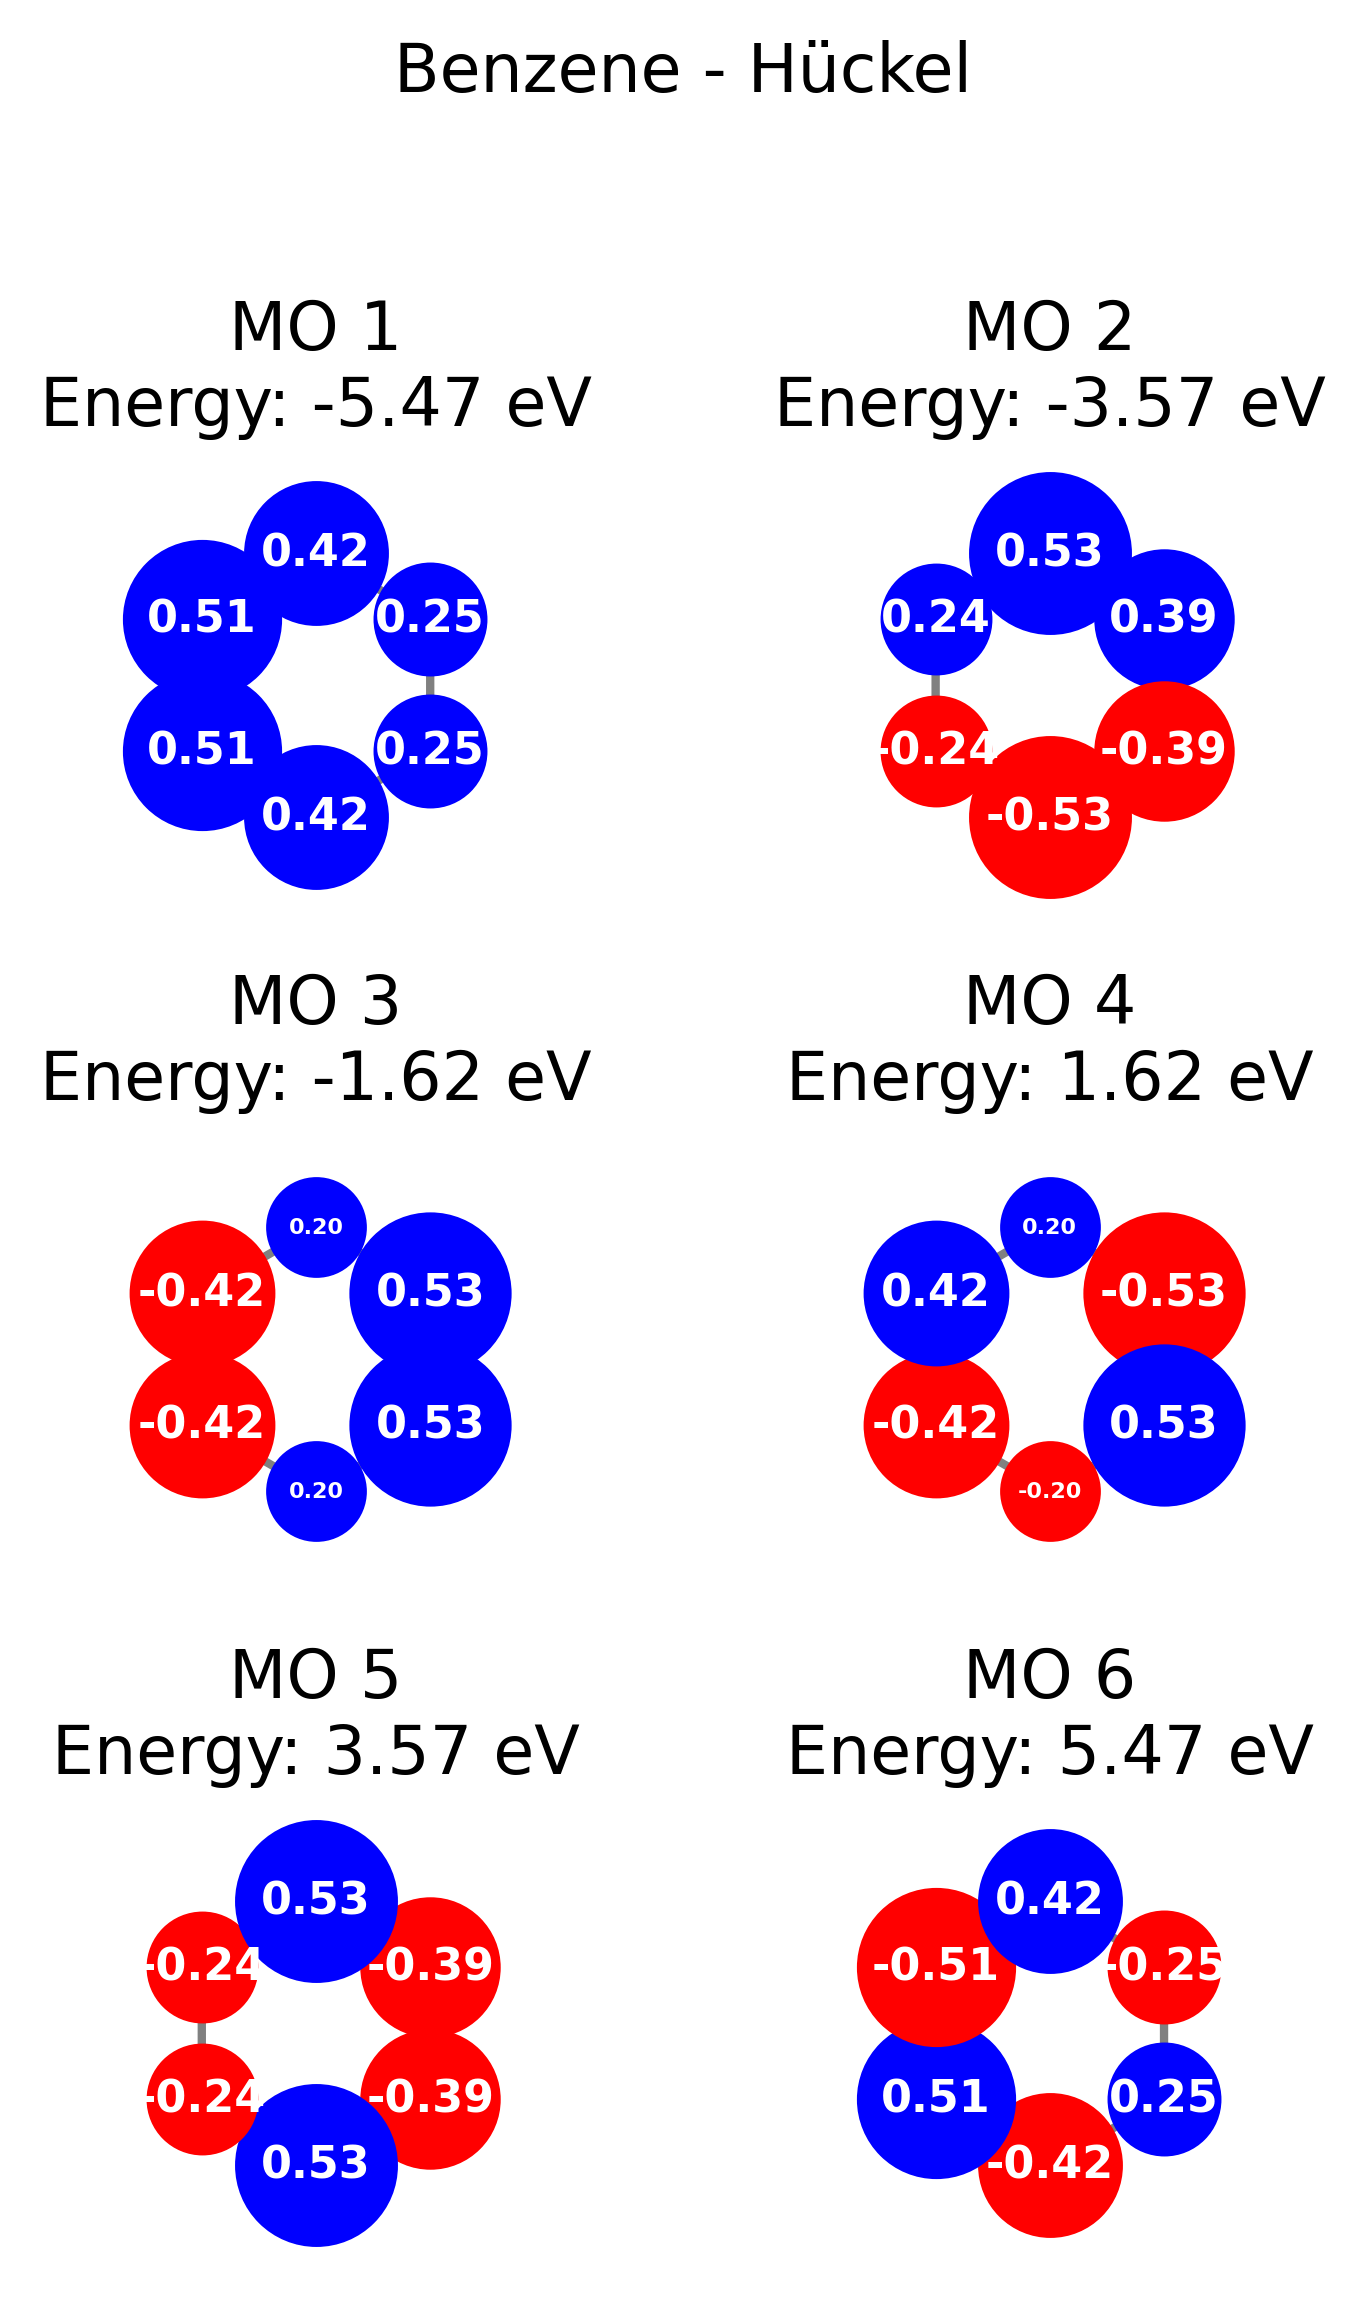

In [53]:
electron_population = [[],[],[],[],[],[]]
S_1_atom = []
S_2_atoms = []
energies = []
for potential in potentials:
    
    benzene.huckel_matrix = H + potential*beta_operator
    benzene.solve_huckel_matrix()
    
    eigenvalues = benzene.eigenvalues
    eigenvectors = benzene.eigenvectors

    D_huckel = pts.making_D(eigenvectors, 6)
    for index, density in enumerate(np.diag(D_huckel)):
        electron_population[index].append(density)

    elec_to_place = 6
    i = 0
    energy = 0
    while elec_to_place >0:
        if elec_to_place > 1:
            elec_in_orbital = 2
        elif elec_to_place == 1:
            elec_in_orbital = 1
        else:
            elec_in_orbital = 0

        energy += elec_in_orbital*(eigenvalues[i]-potential*(eigenvectors.T[i] @ beta_operator @ eigenvectors.T[i].T))
        elec_to_place -= elec_in_orbital
        i+=1
        
    energies.append(energy)

    occ_orbitals = eigenvectors.T[:3].round(6)
    
    S_ohm_1_atom= []
    S_ohm_2_atoms = []
    for i in range(6):
        atom_i = np.zeros((6,6))
        atom_i[i][i] = 1
        eigvals_i = np.linalg.eigvalsh(occ_orbitals @ atom_i @ occ_orbitals.T).round(6)
        S_ohm_i = 0
        for eigenvalue in eigvals_i:
            if (eigenvalue != 0): 
                S_ohm_i -= (eigenvalue*np.log(eigenvalue) + (1-eigenvalue)*np.log(1-eigenvalue))
        S_ohm_1_atom.append(2*S_ohm_i)
        for j in range(i+1,6):
            atom_j = np.zeros((6,6))
            atom_j[j][j] = 1    
            atom_i_j = atom_i + atom_j
            eigvals_i_j = np.linalg.eigvalsh(occ_orbitals @ atom_i_j @ occ_orbitals.T).round(6)
            S_ohm_i_j = 0
            for eigenvalue in eigvals_i_j:
                if (eigenvalue != 0): 
                    S_ohm_i_j -= (eigenvalue*np.log(eigenvalue) + (1-eigenvalue)*np.log(1-eigenvalue))
            S_ohm_2_atoms.append(2*S_ohm_i_j)
    S_1_atom.append(S_ohm_1_atom)
    S_2_atoms.append(S_ohm_2_atoms)



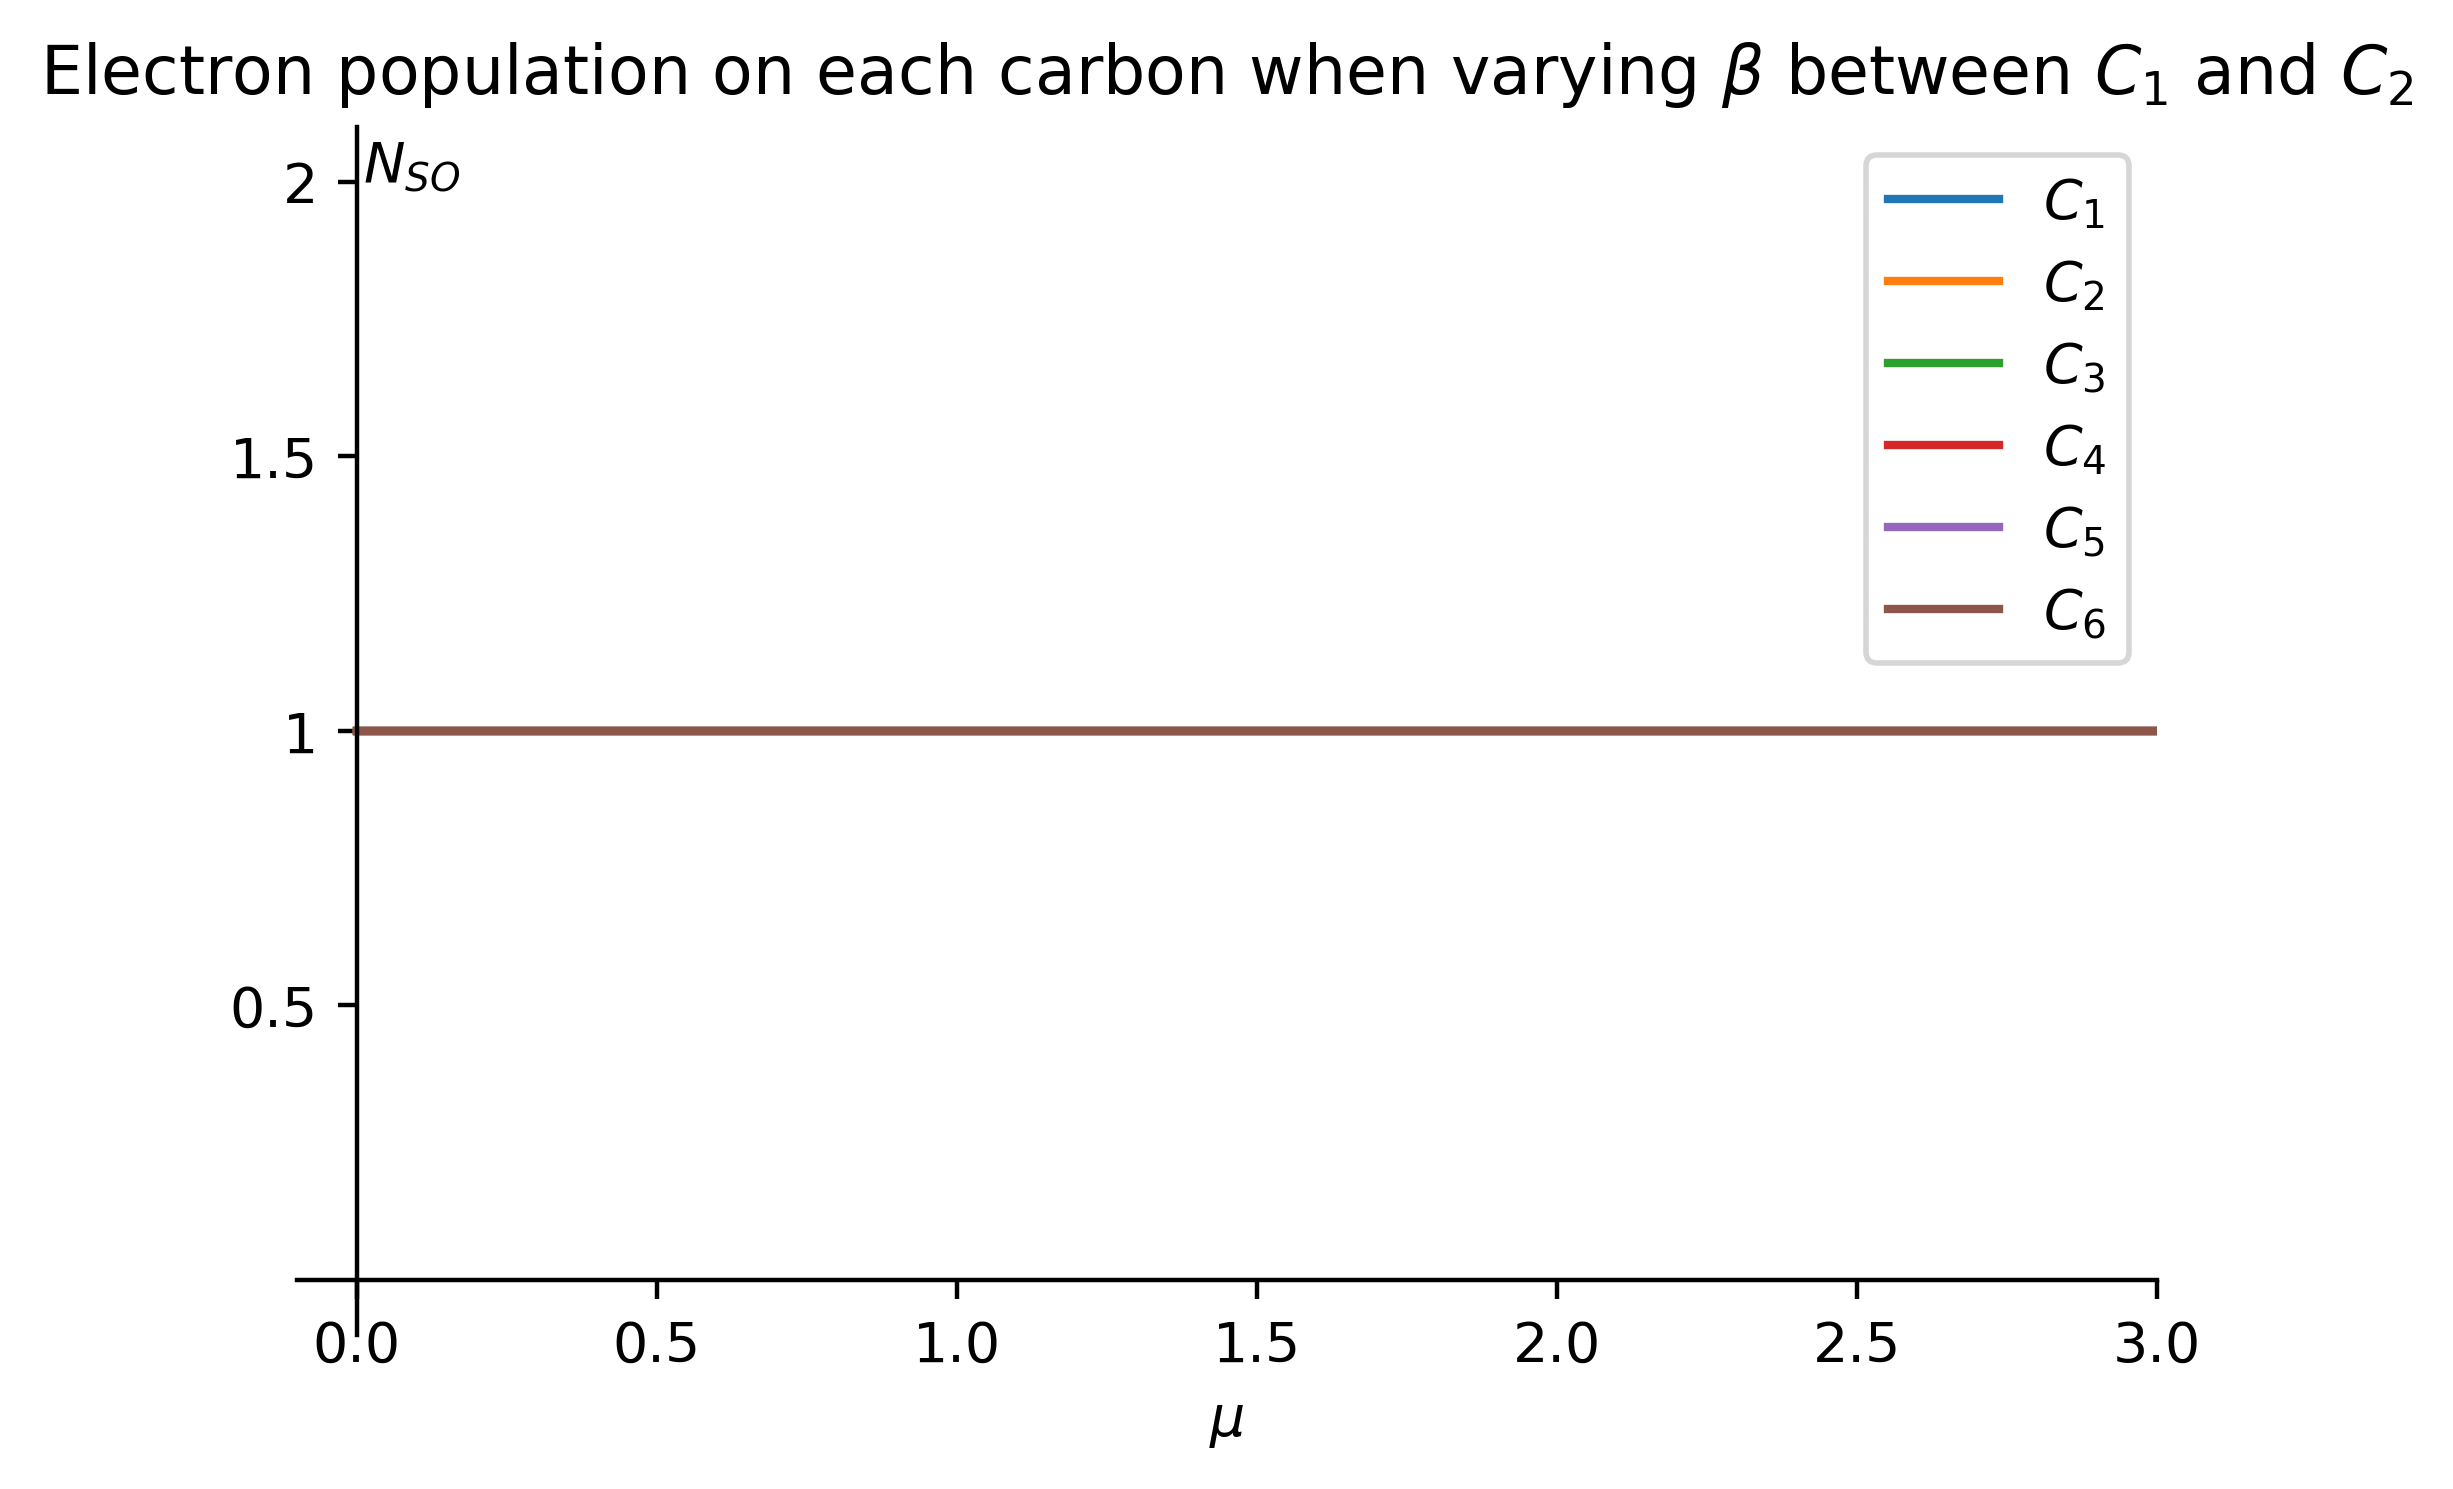

In [44]:
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 3)
ax.set_ylim(-0.1, 2.1)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5, 2])
ax.set_yticklabels(['0.5', '1', '1.5', '2'])


# Plot de gegevens
x= [5,0,1,2,3,4]
for index, atom in enumerate(x):
    plt.plot(potentials, electron_population[atom], label=f'$C_{index+1}$')

# Benoem de assen en titel 
plt.title('Electron population on each carbon when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$\mu$')
ax.text(0.01, 2, '$N_{SO}$', rotation=0)

# Legenda
plt.legend()

# Toon de plot
plt.show()


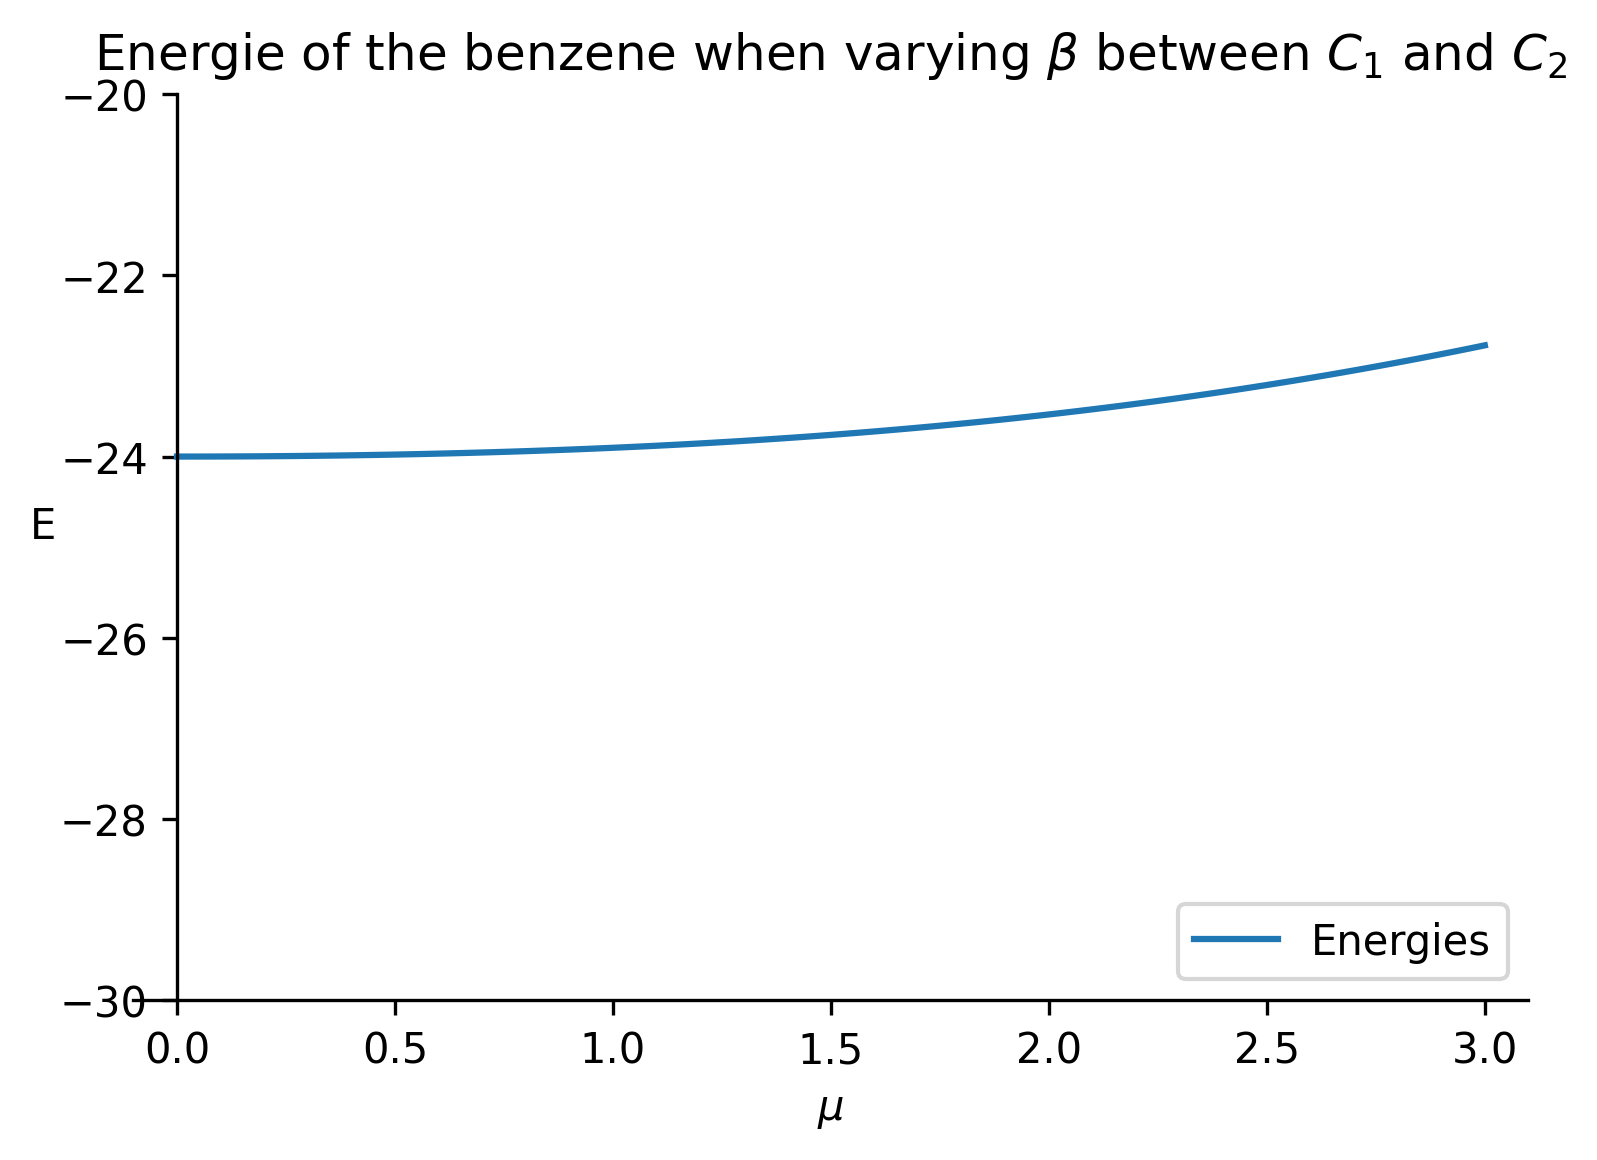

In [45]:
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi=300)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-30, -20)


# Stel de locaties en labels van de y-ticks in


# Plot de gegevens
plt.plot(potentials, energies, label=f'Energies')


# Benoem de assen en titel 
plt.title('Energie of the benzene when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$\mu$', rotation=0)
ax.set_ylabel('E', rotation=0)

# Legenda
plt.legend(loc= 'lower right')

# Toon de plot
plt.show()


[0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 0.9999999999999999, 1.0000000000000002, 0.9999999999999997, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 0.9999999999999999, 1.0000000000000002, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0000000000000004, 0.9999999999999999, 1.0, 1.0000000000000002, 1.0, 0.9999999999999997, 1.0, 1.0, 1.0, 1.0, 1.0000000000000004, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999998, 1.0, 1.0, 1.0000000000000002, 0.9999999999999998, 1.0, 1.0, 0.9999999999999999, 0.9999999999999998, 1.0000000000000002, 1.0, 1.0000000000000002, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999998, 0.9999999999999999, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0000000000000002, 1.0000000000000002, 1.0, 0.9999999999999999, 1.0000000000000002,

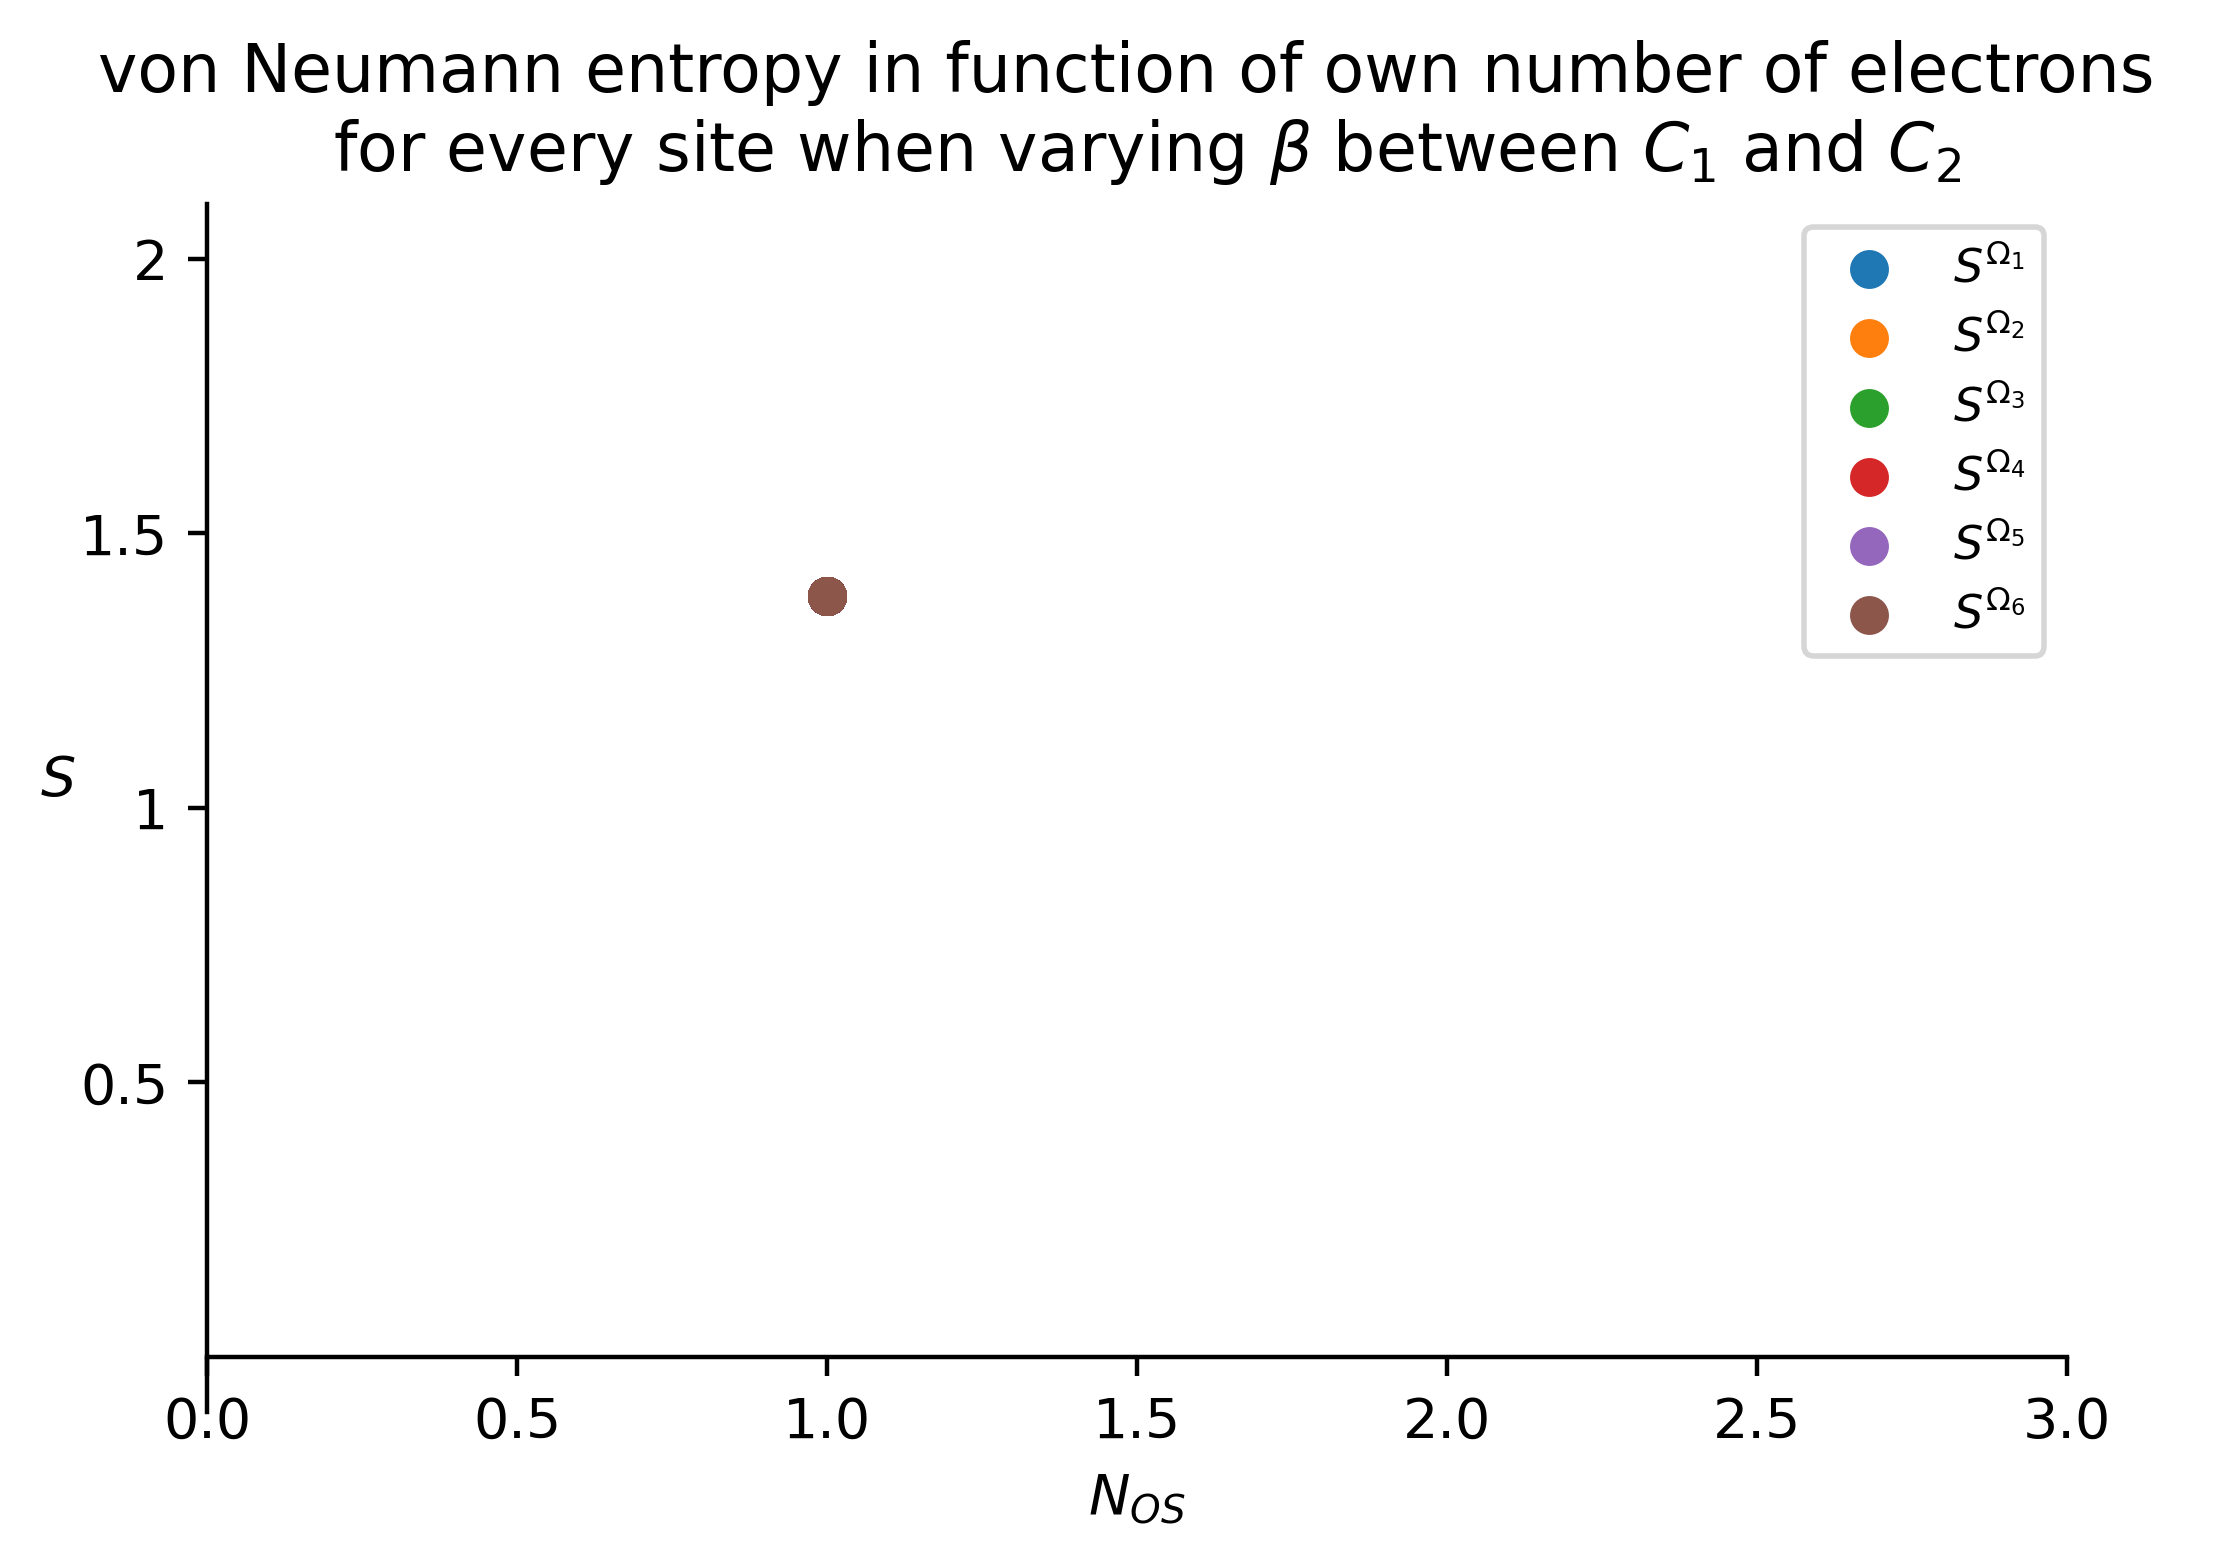

In [46]:
import matplotlib.pyplot as plt
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(0, 3)
ax.set_ylim(-0.1, 2.1)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5, 2])
ax.set_yticklabels(['0.5', '1', '1.5', '2'])


# Plot de gegevens
for index, population in enumerate(electron_population):
    plt.scatter(population, [sublijst[index] for sublijst in S_1_atom], label=r'$S^{Ω_{%s}}$' % str(index+1))
    print(population)
    print([sublijst[index] for sublijst in S_1_atom])
# Benoem de assen en titel 
plt.title('von Neumann entropy in function of own number of electrons \n for every site when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$N_{OS}$')
ax.set_ylabel('$S$', rotation=0)

# Legenda
plt.legend(fontsize='small')

# Toon de plot
plt.show()


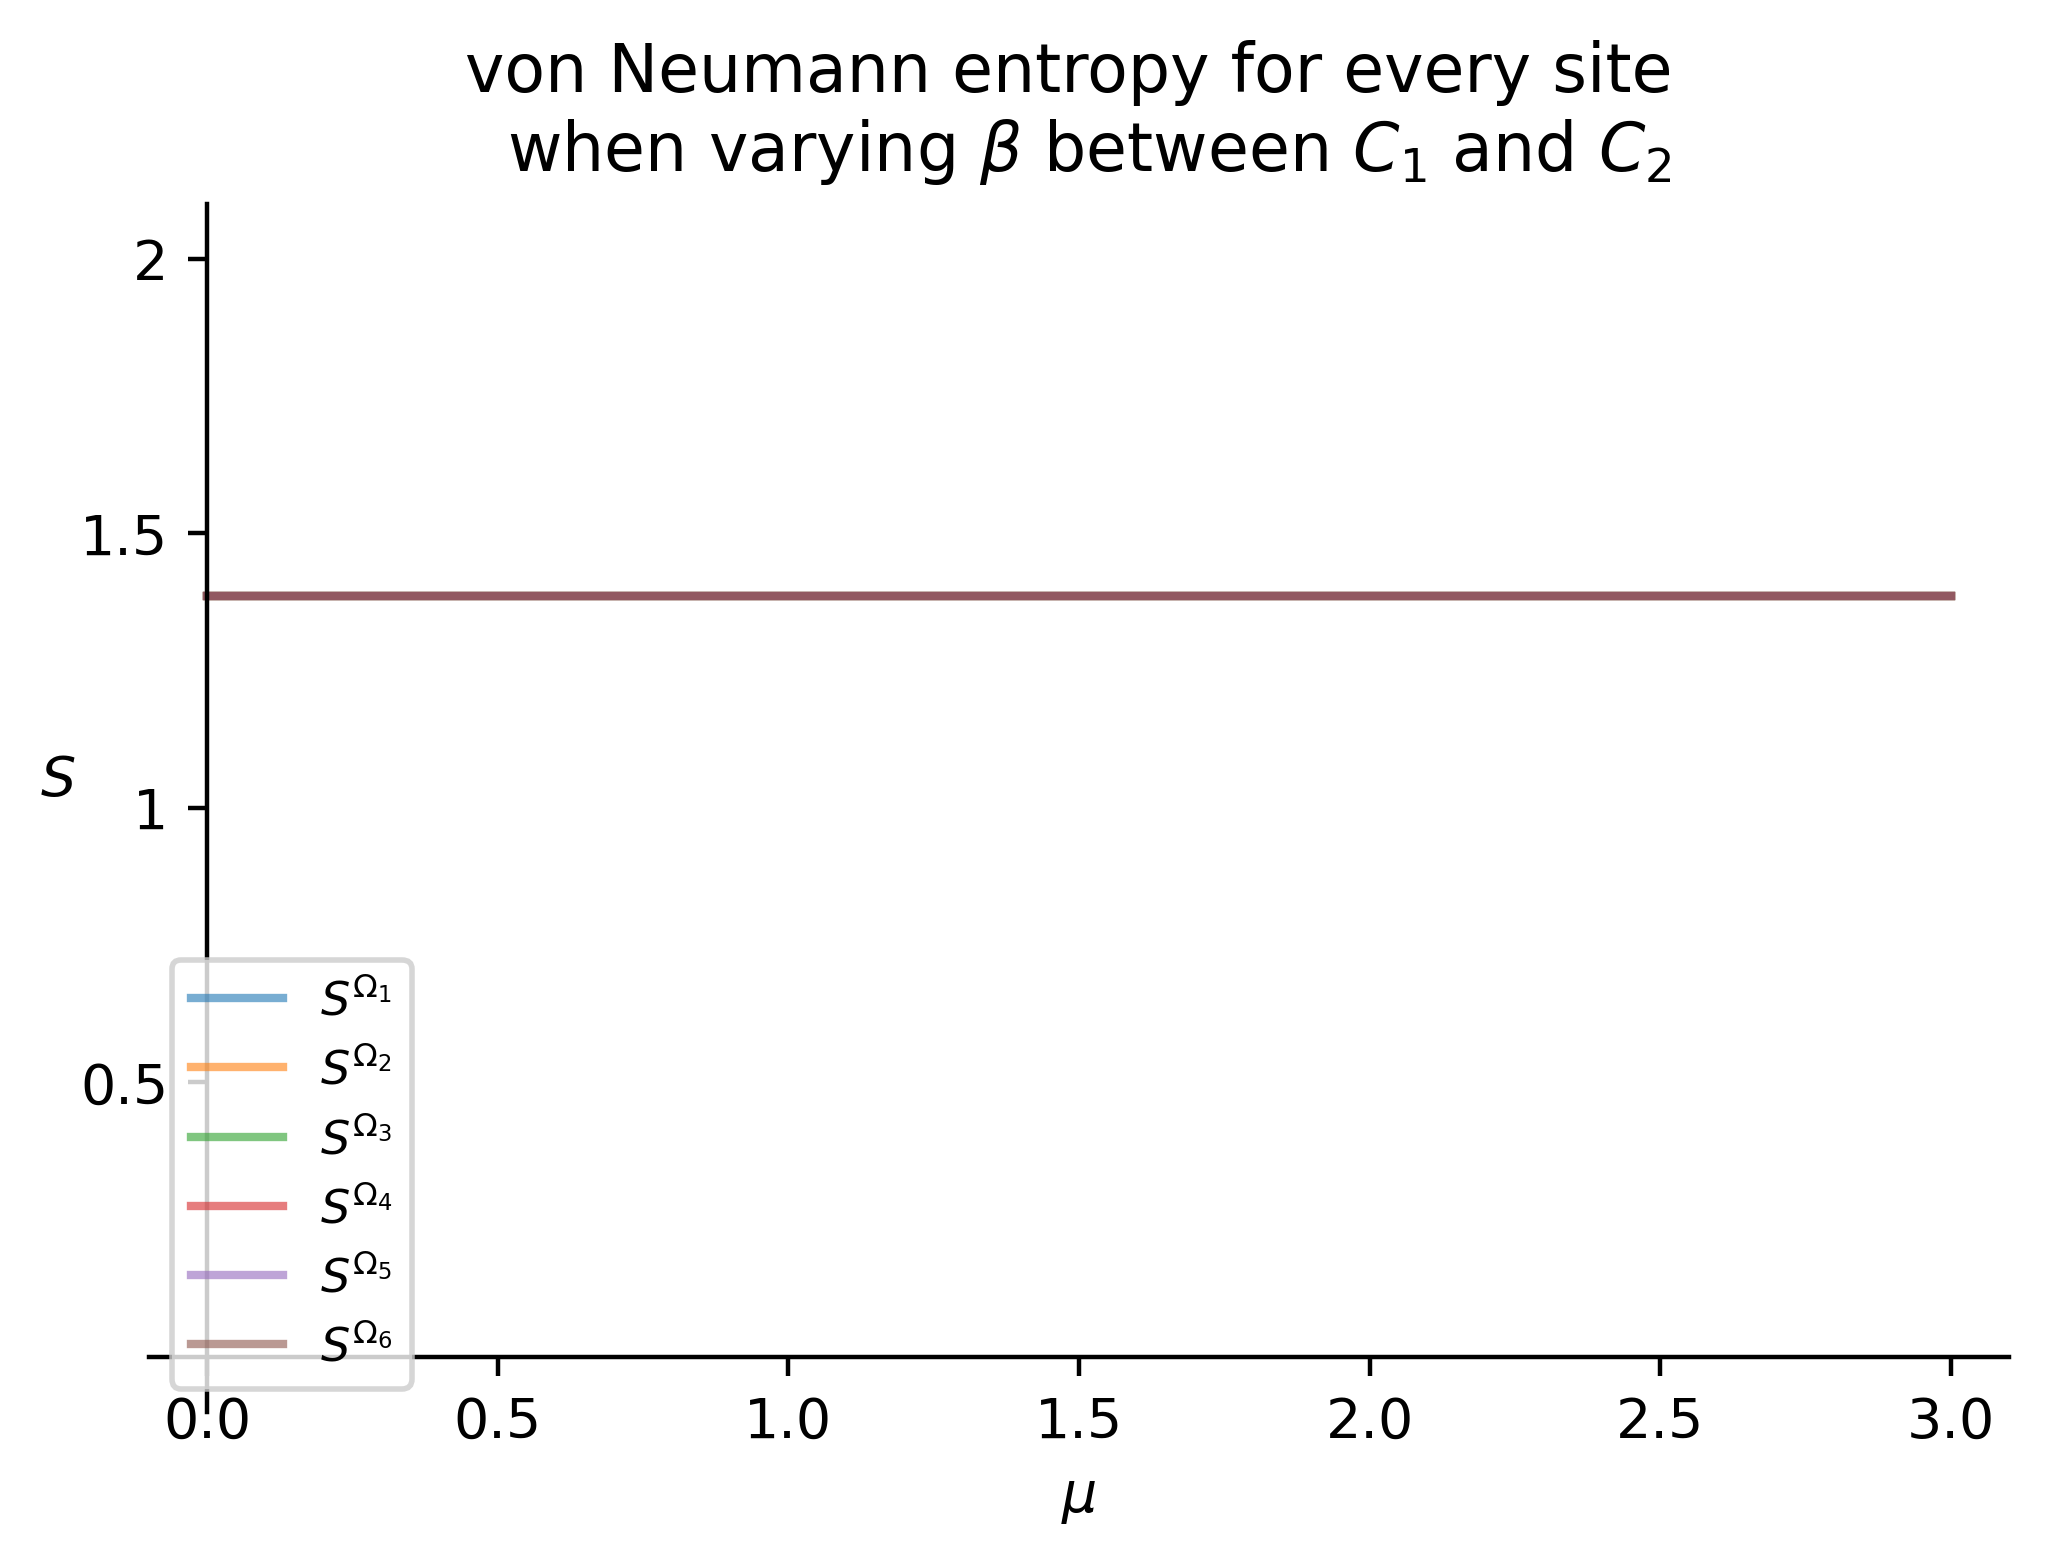

In [47]:


import matplotlib.pyplot as plt
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-0.1, 2.1)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5, 2])
ax.set_yticklabels(['0.5', '1', '1.5', '2'])


# Plot de gegevens
for i in range(6):
    plt.plot(potentials, [sublijst[i] for sublijst in S_1_atom], alpha = 0.6, label=r'$S^{Ω_{%s}}$' % str(i+1))

# Benoem de assen en titel 
plt.title('von Neumann entropy for every site \n when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$S$', rotation=0)

# Legenda
plt.legend(fontsize='small')

# Toon de plot
plt.show()


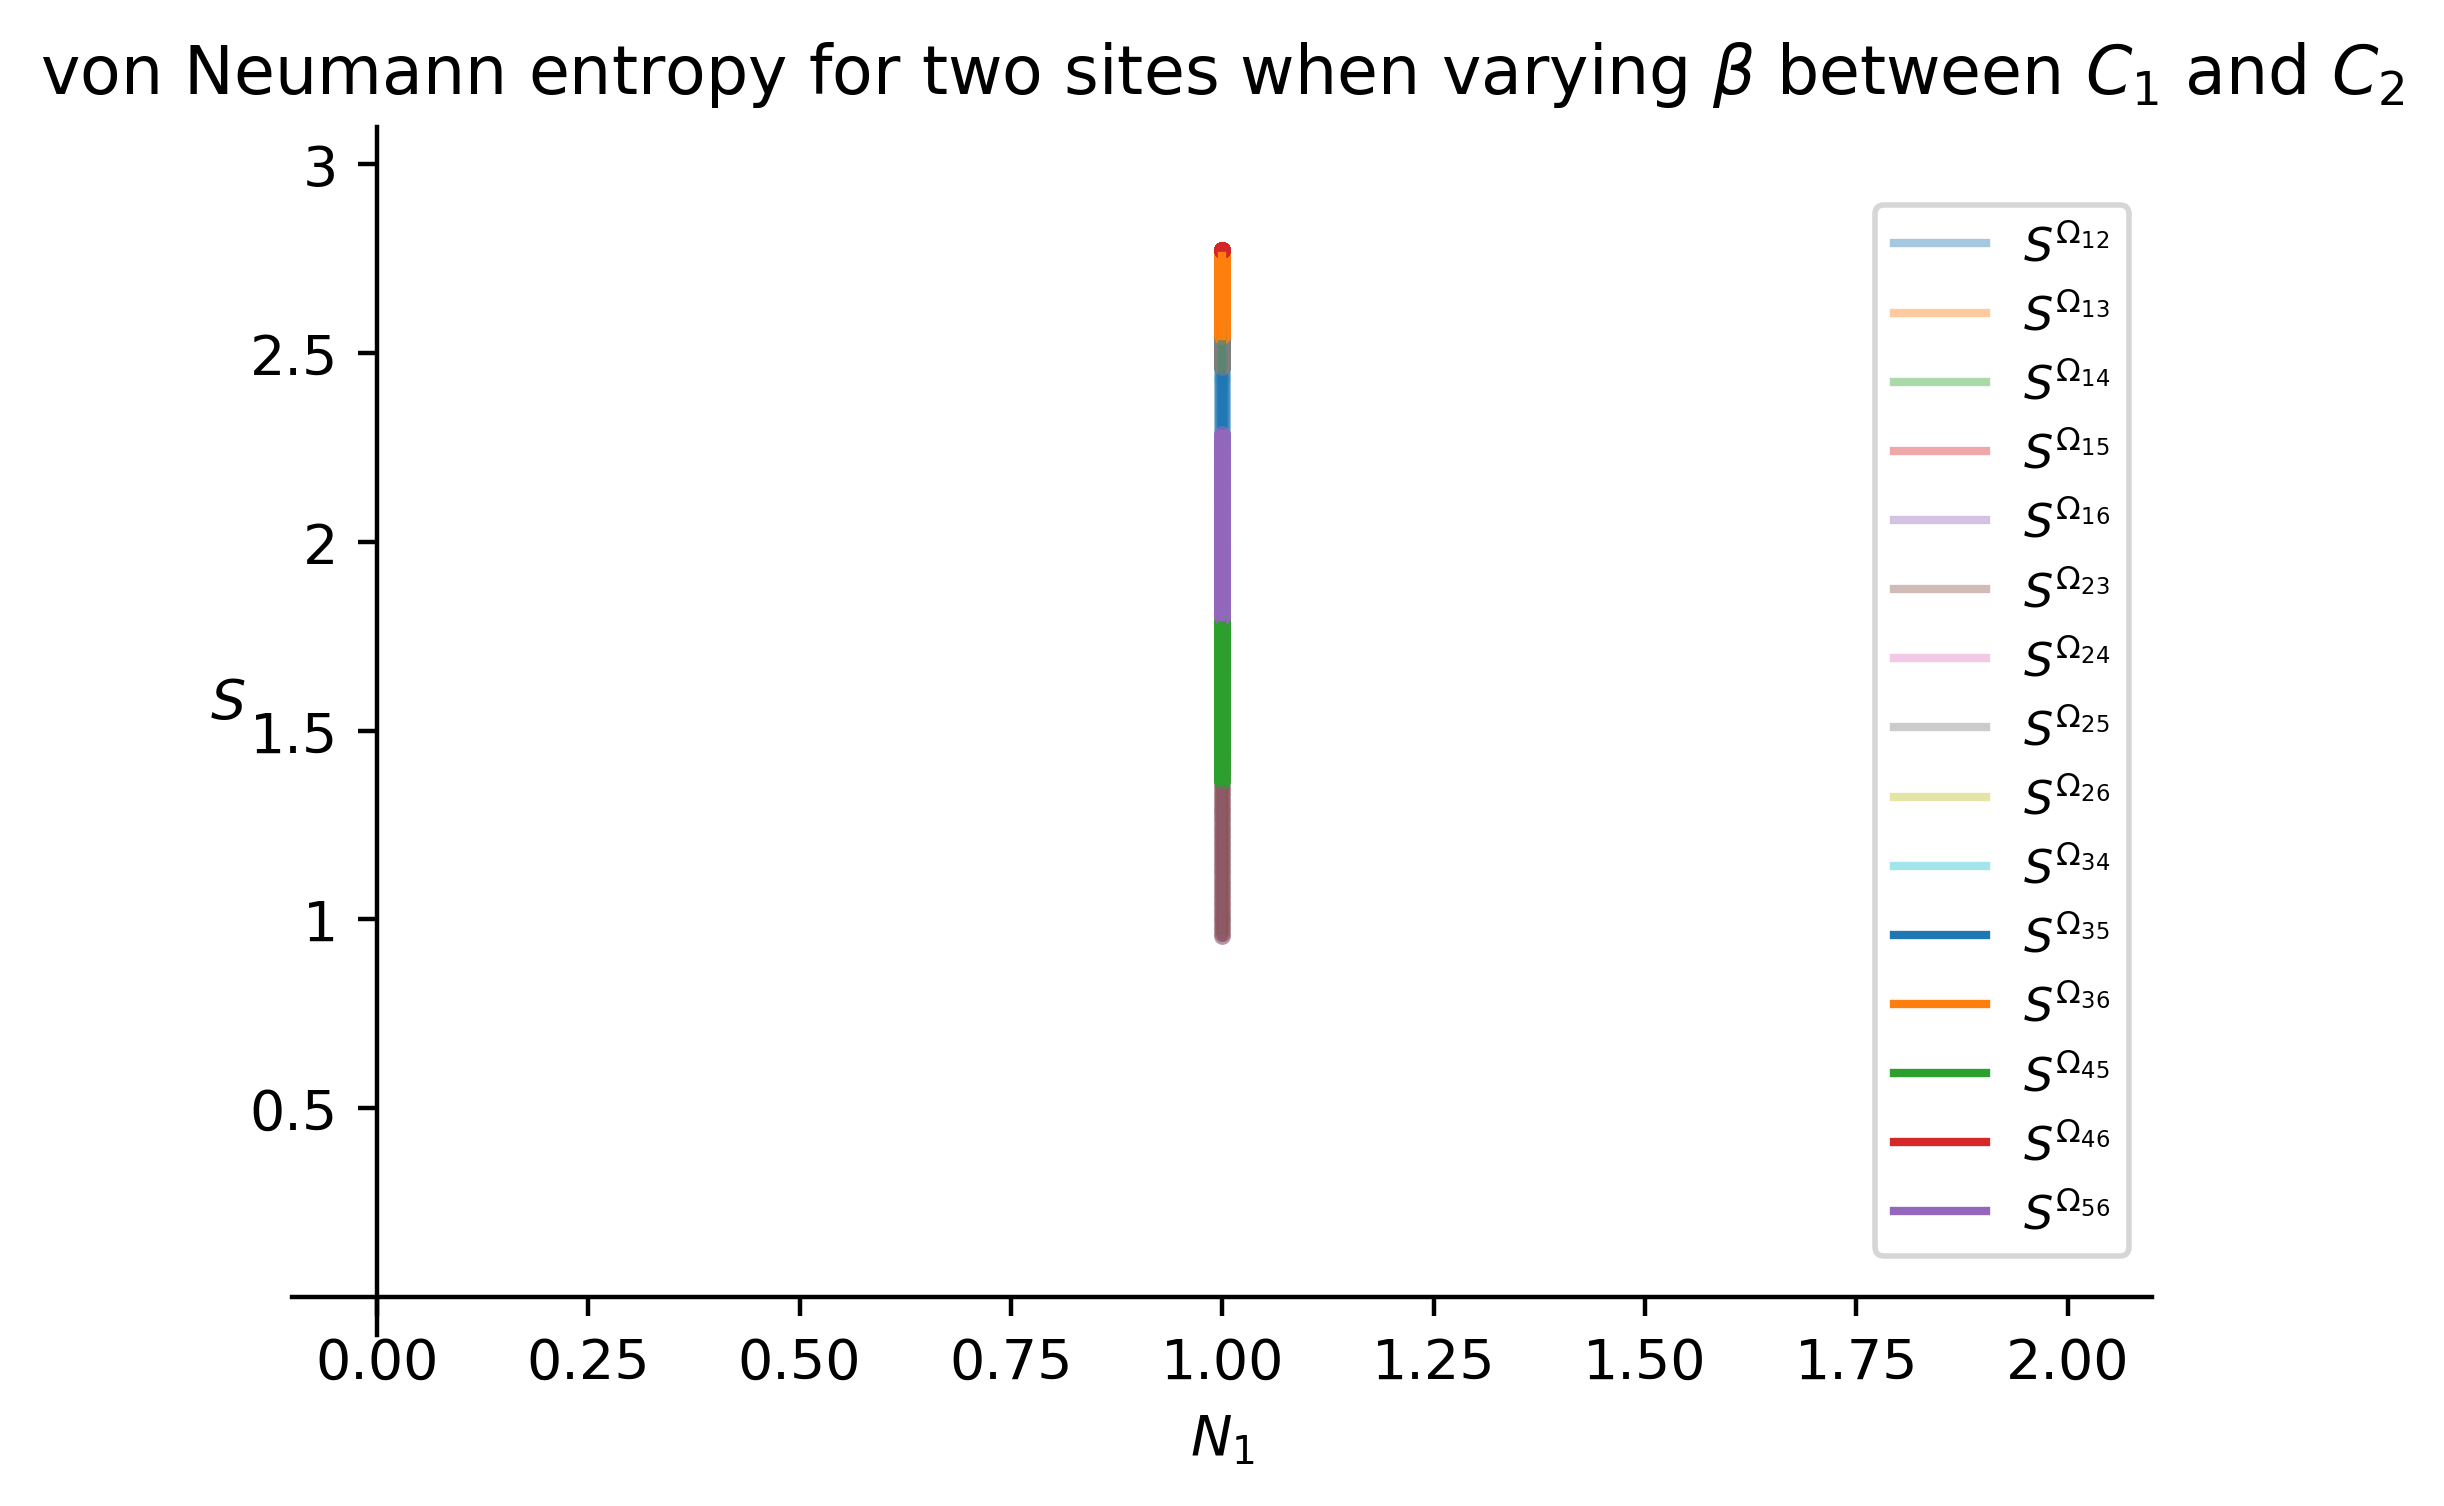

In [48]:


import matplotlib.pyplot as plt
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(-0.1, 3.1)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5, 2, 2.5, 3])
ax.set_yticklabels(['0.5', '1', '1.5', '2', '2.5', '3'])


# Plot de gegevens
index = 0
for i in range(6):
    for j in range(i+1, 6):
        if index >9:
            alpha = 1
        else:
            alpha = 0.4
        atoms = str(i+1)+str(j+1)
        plt.plot(electron_population[0], [sublijst[index] for sublijst in S_2_atoms], alpha = alpha, label=r'$S^{Ω_{%s}}$' %atoms)
        plt.scatter(electron_population[0], [sublijst[index] for sublijst in S_2_atoms], s=4, alpha = alpha)
        index+=1
# Benoem de assen en titel 
plt.title('von Neumann entropy for two sites when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$N_1$')
ax.set_ylabel('$S$', rotation=0)

# Legenda
plt.legend(fontsize='small',loc = 'right')

# Toon de plot
plt.show()


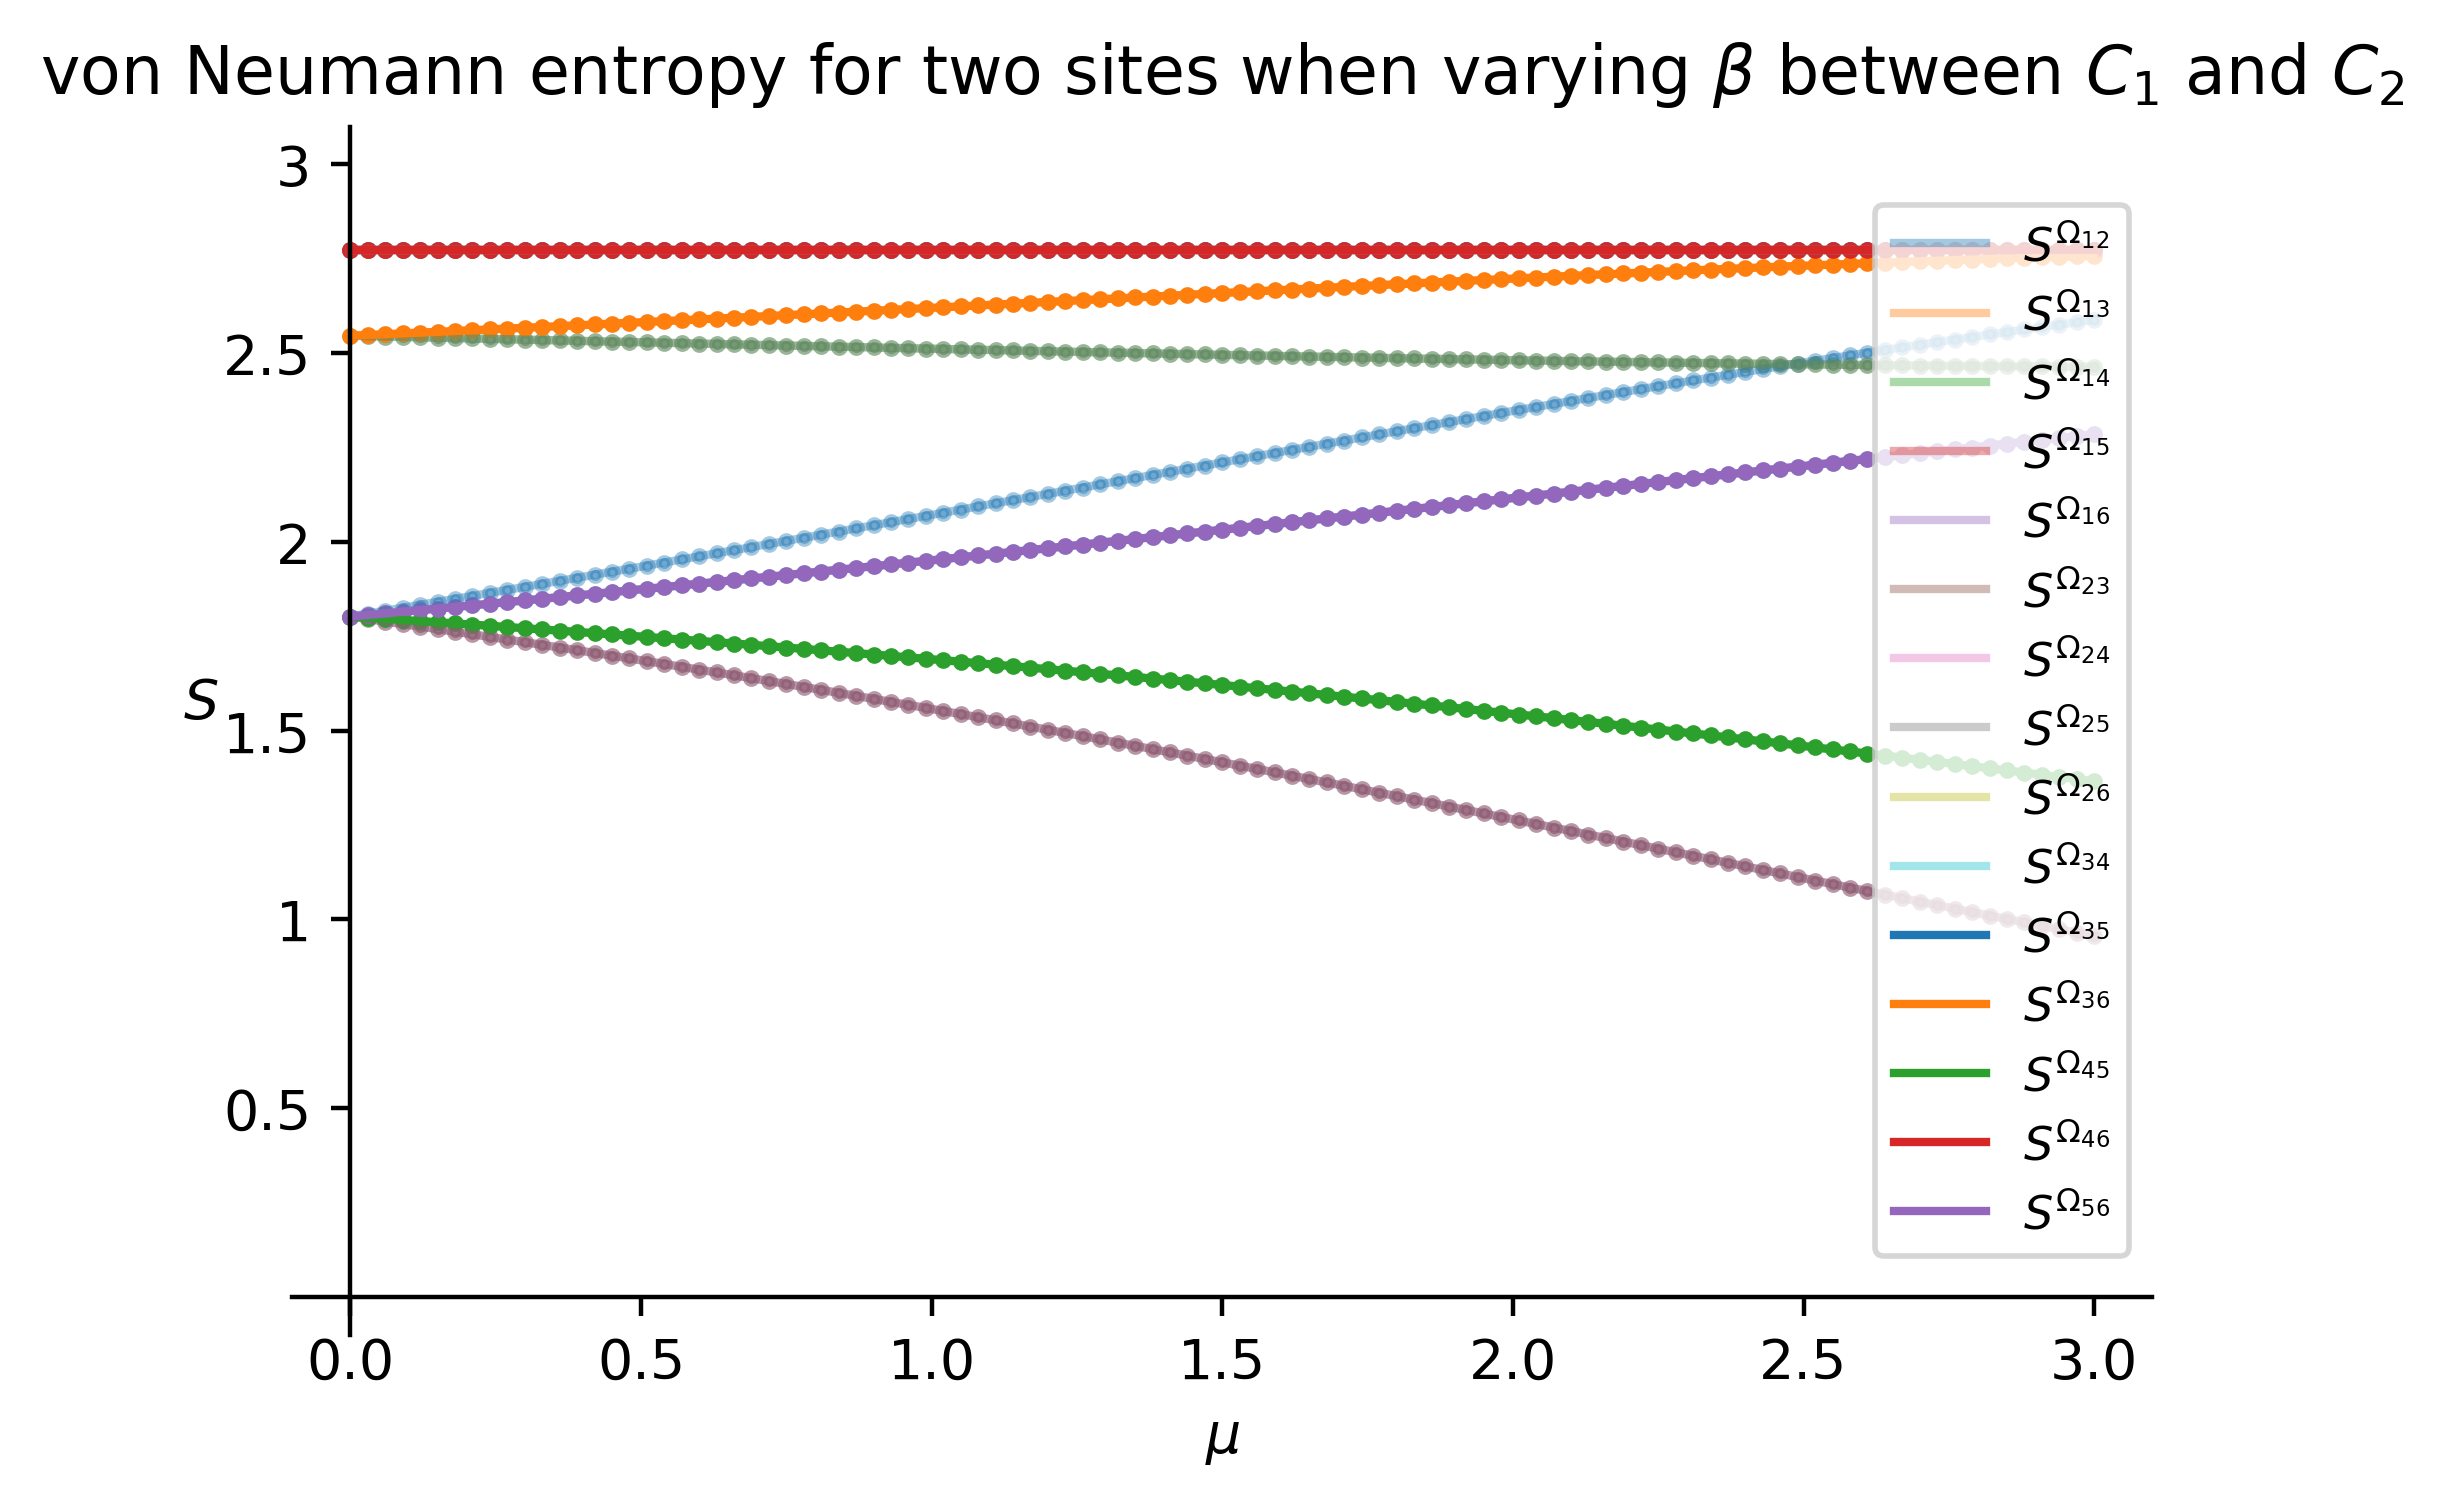

In [49]:


import matplotlib.pyplot as plt
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-0.1, 3.1)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5, 2, 2.5, 3])
ax.set_yticklabels(['0.5', '1', '1.5', '2', '2.5', '3'])


# Plot de gegevens
index = 0
for i in range(6):
    for j in range(i+1, 6):
        if index > 9:
            alpha = 1
        else:
            alpha = 0.4
        atoms = (str(i+1)+str(j+1))
        ax.plot(potentials, [sublijst[index] for sublijst in S_2_atoms], alpha=alpha, label=r'$S^{Ω_{%s}}$' % atoms)
        ax.scatter(potentials, [sublijst[index] for sublijst in S_2_atoms], s=4, alpha=alpha)
        index += 1
# Benoem de assen en titel 
plt.title('von Neumann entropy for two sites when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$S$', rotation=0)

# Legenda
plt.legend(fontsize='small',loc = 'right')

# Toon de plot
plt.show()


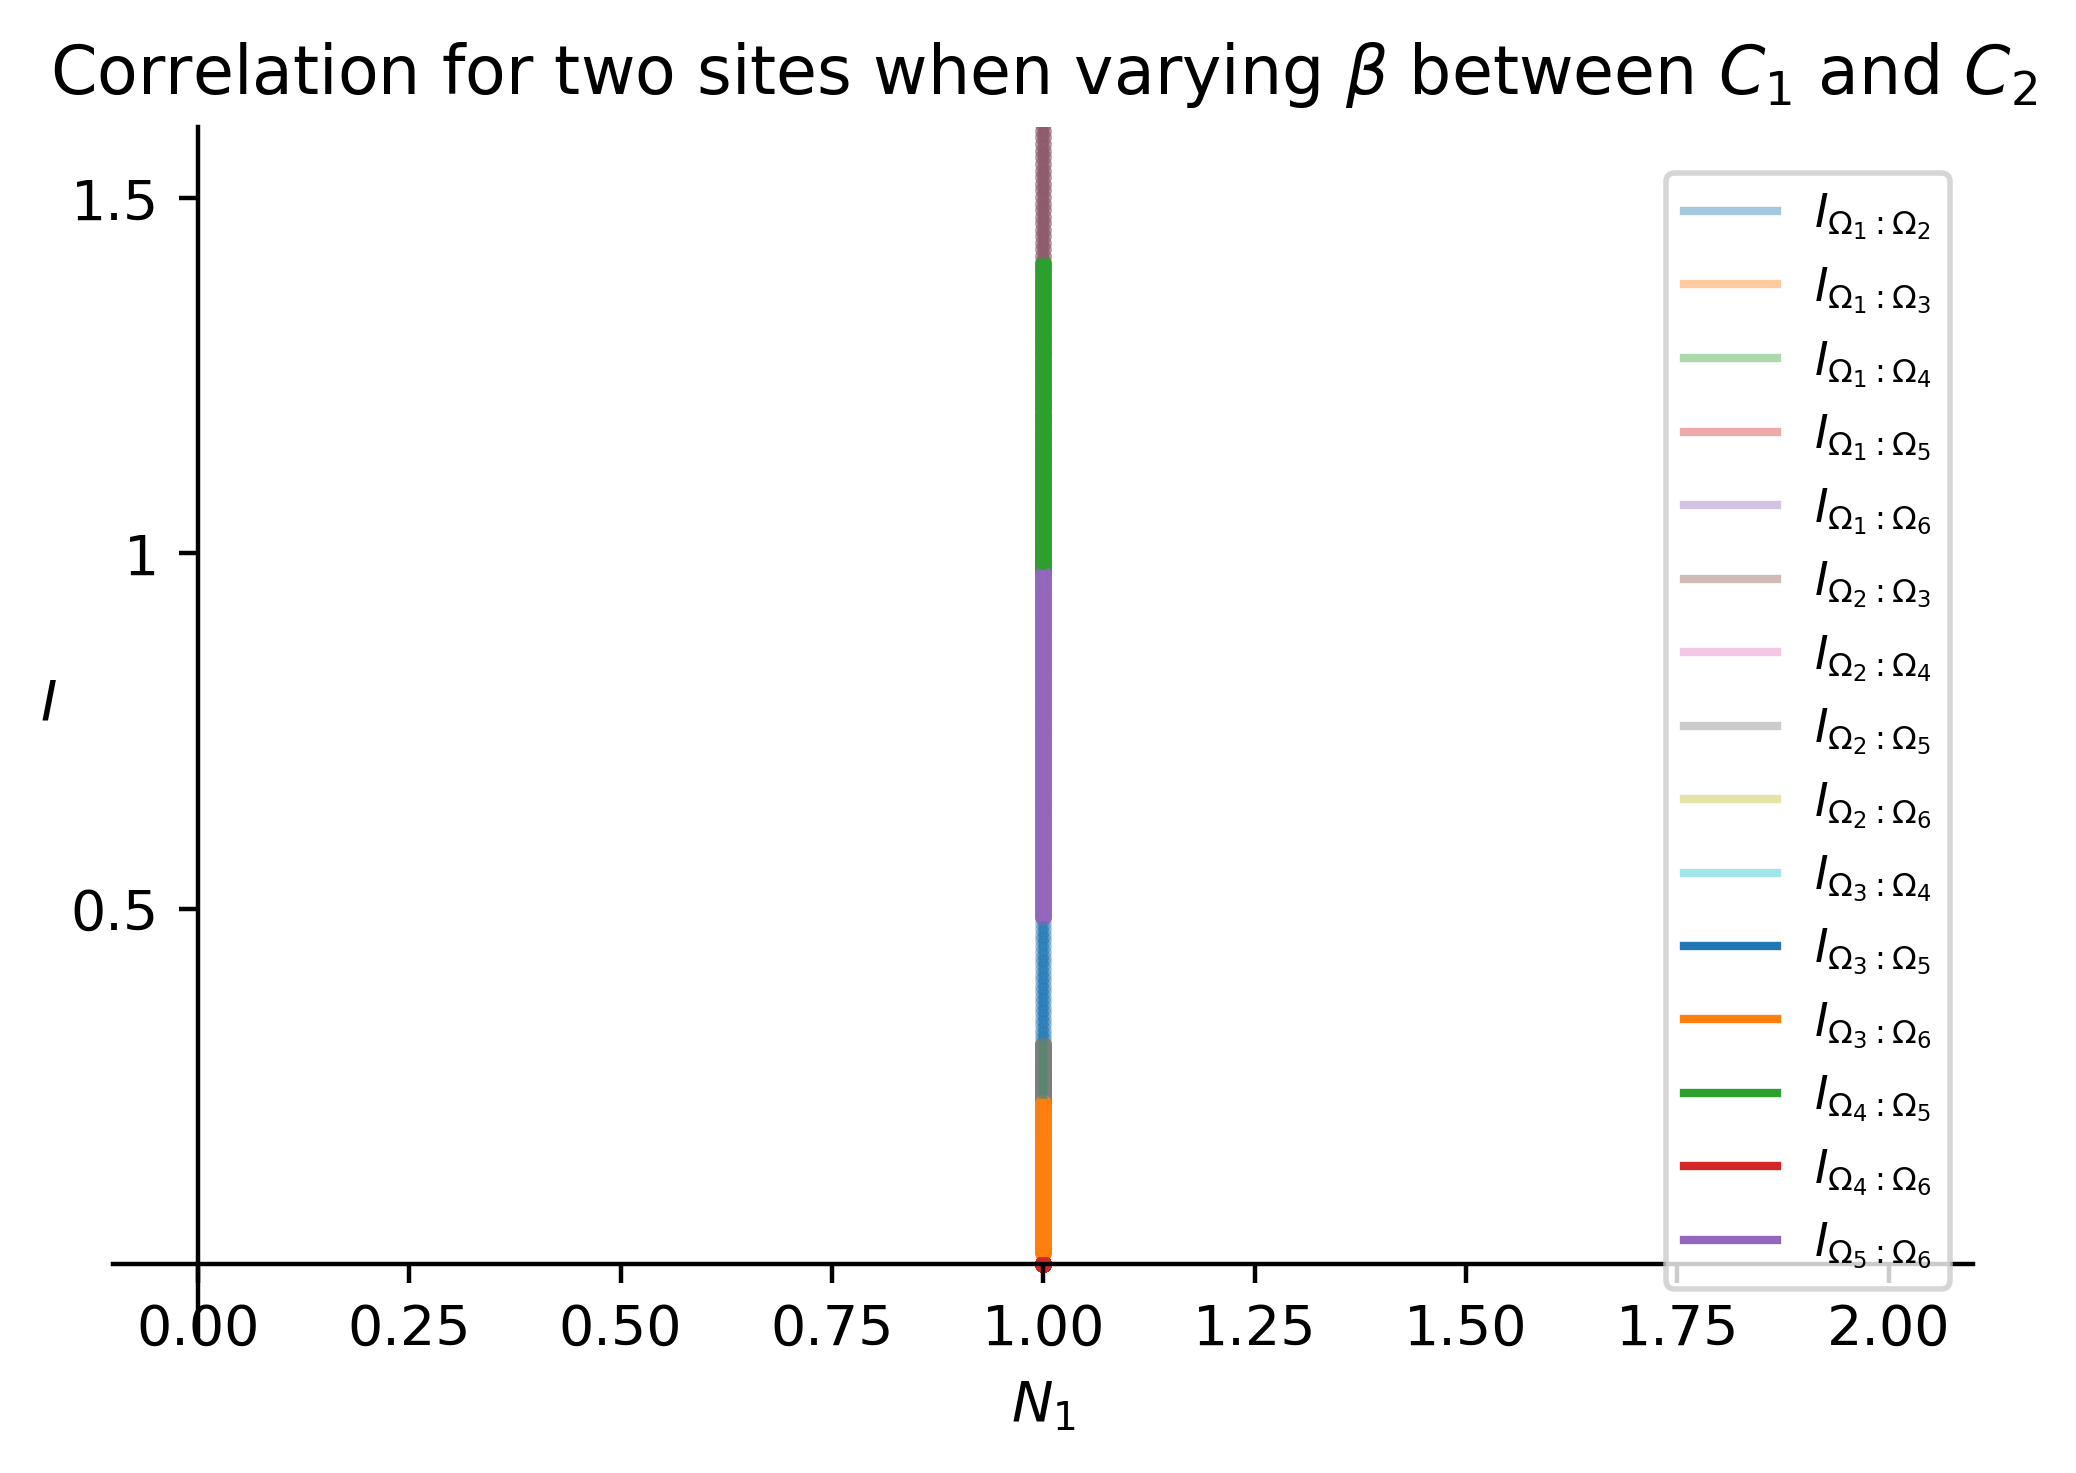

In [50]:
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(-0.1, 1.6)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5])
ax.set_yticklabels(['0.5', '1', '1.5'])


# Plot de gegevens
index = 0
for i in range(6):
    for j in range(i+1, 6):
        if index >9:
            alpha = 1
        else:
            alpha = 0.4
        atoms = (str(i+1),str(j+1))
        plt.plot(electron_population[0], [S_1_atom[k][i] + S_1_atom[k][j] - sublijst[index] for  k, sublijst in enumerate(S_2_atoms)], alpha = alpha, label=r'$I_{Ω_{%s}: Ω_{%s}}$' %atoms)
        plt.scatter(electron_population[0], [S_1_atom[k][i] + S_1_atom[k][j] - sublijst[index] for  k, sublijst in enumerate(S_2_atoms)], s=4, alpha = alpha)
        index+=1
        
# Benoem de assen en titel 
plt.title('Correlation for two sites when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$N_1$')
ax.set_ylabel('$I$', rotation=0)

# Legenda
plt.legend(fontsize='small',loc = 'right')

# Toon de plot
plt.show()


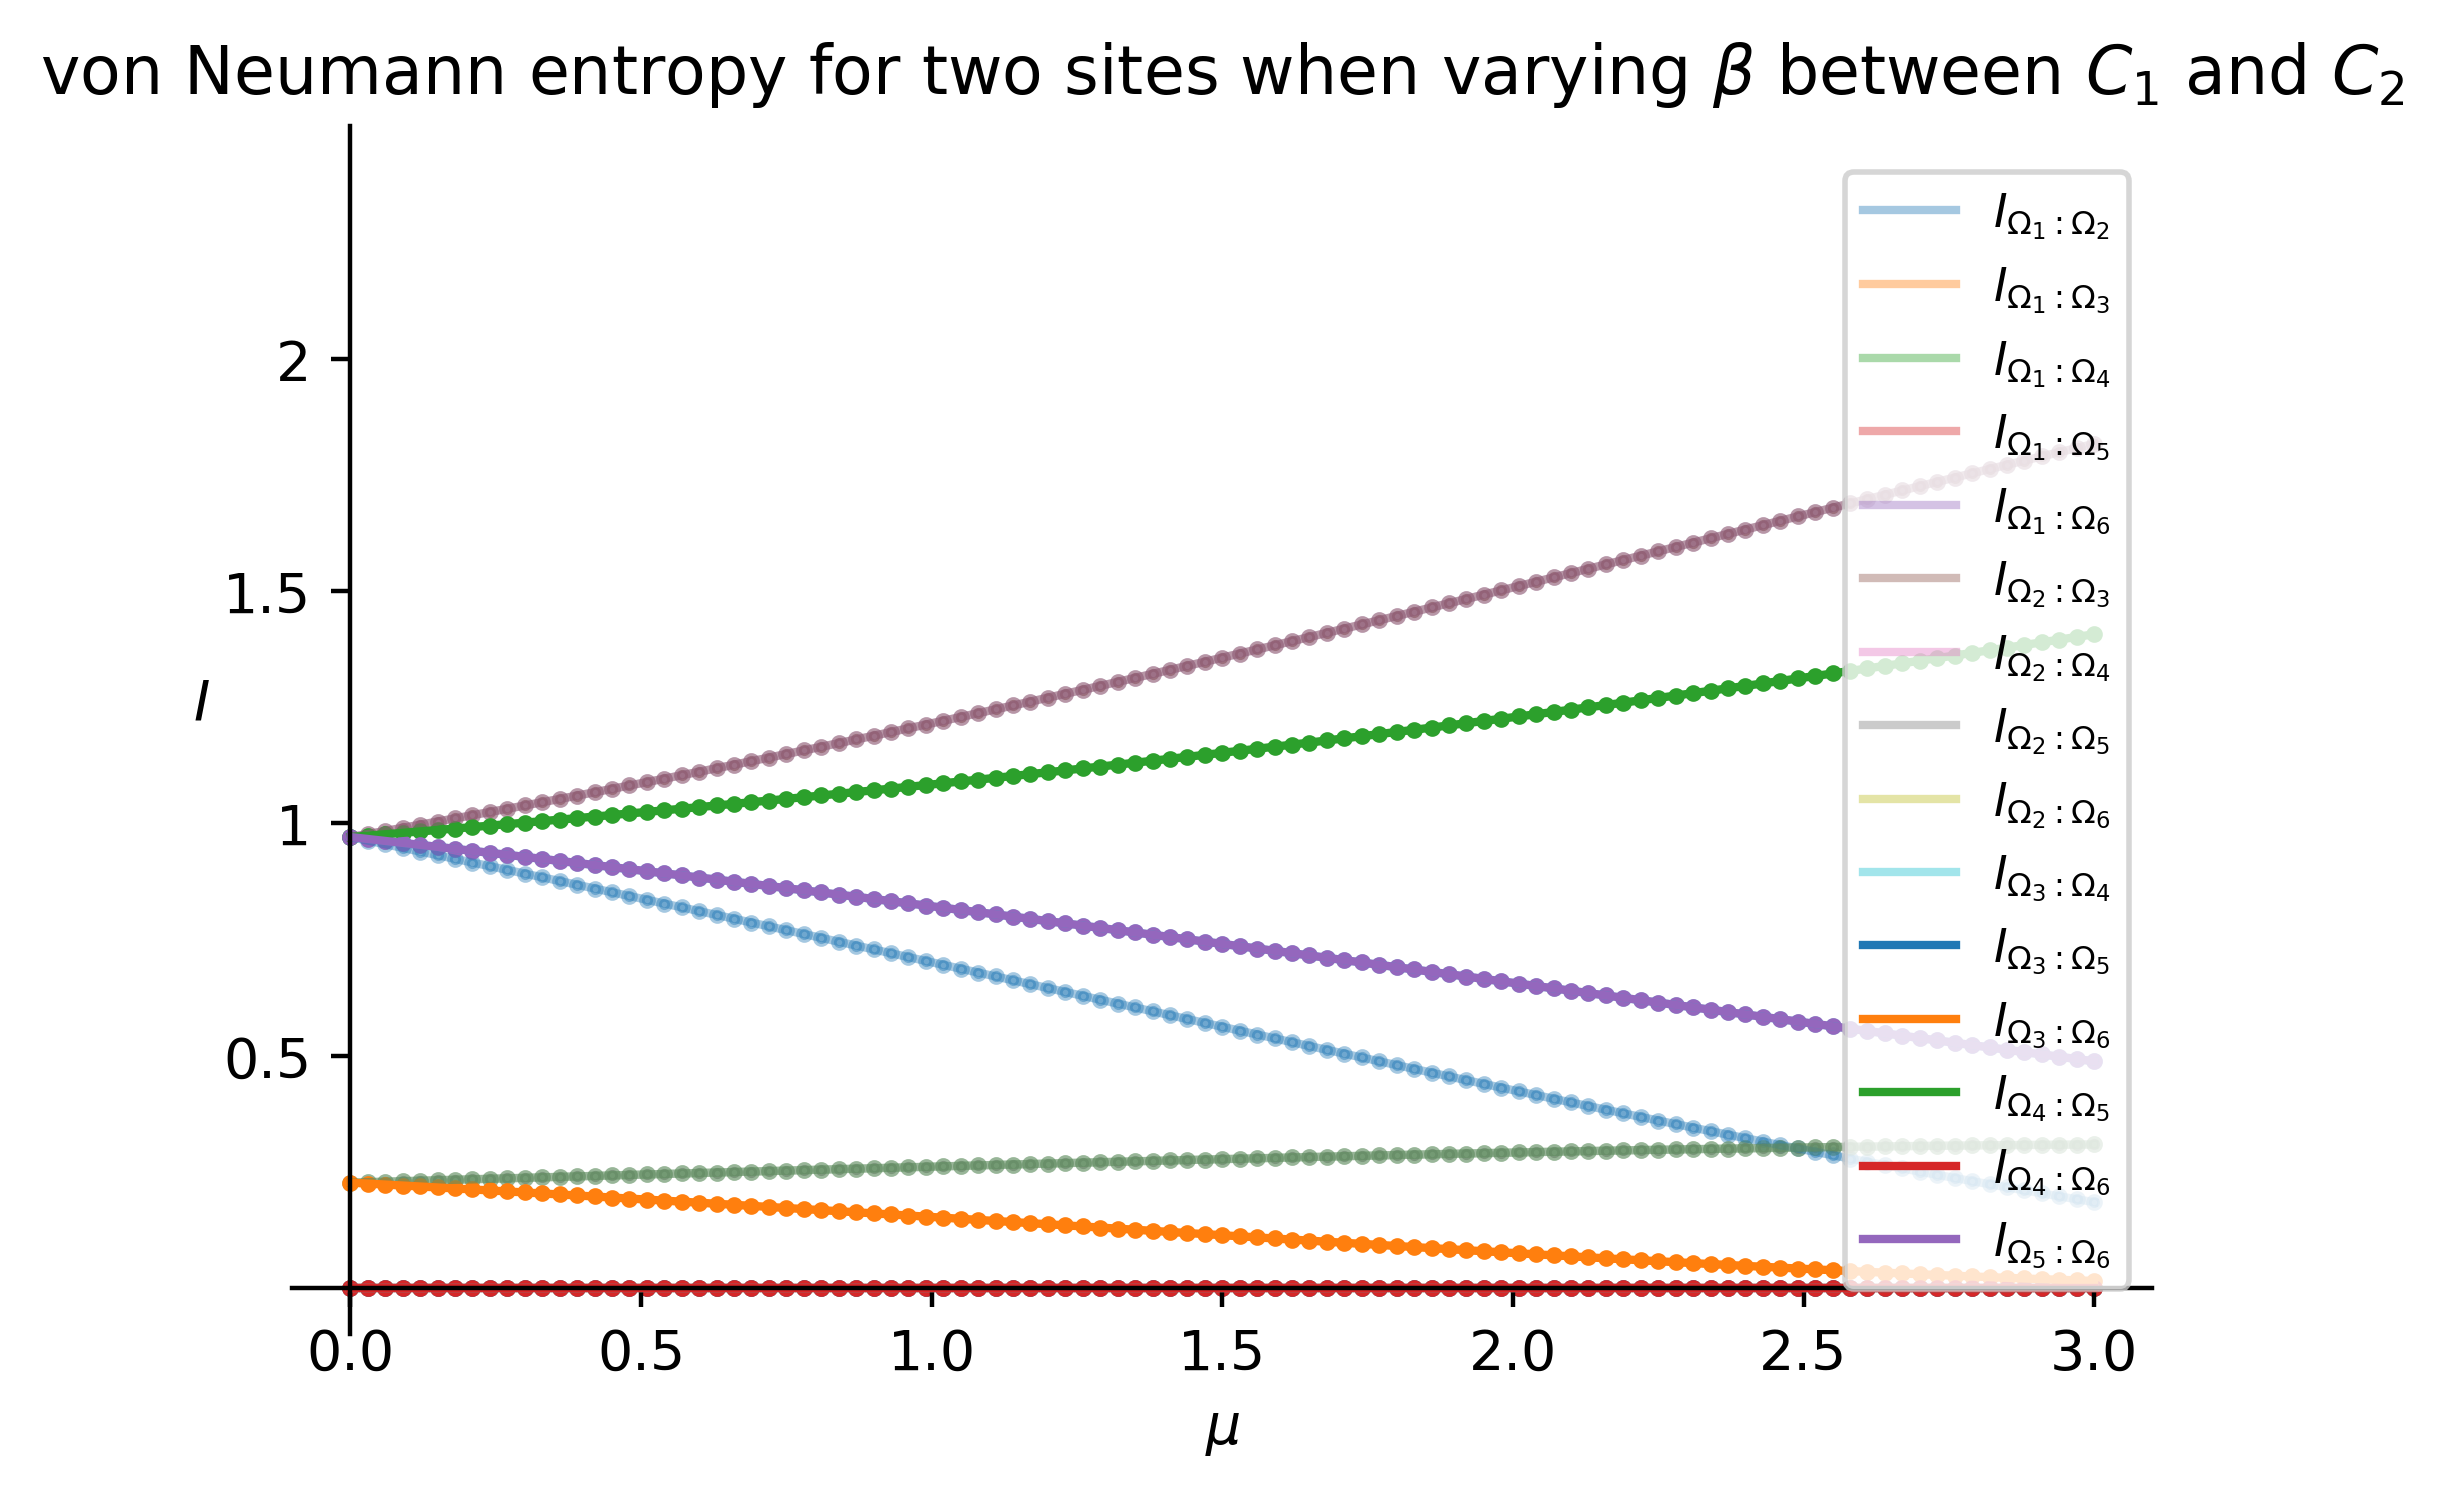

In [51]:
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 3.1)
ax.set_ylim(-0.1, 2.5)


# Stel de locaties en labels van de y-ticks in
ax.set_yticks([0.5, 1, 1.5, 2])
ax.set_yticklabels(['0.5', '1', '1.5', '2'])


# Plot de gegevens
index = 0
for i in range(6):
    for j in range(i+1, 6):
        if index >9:
            alpha = 1
        else:
            alpha = 0.4
        atoms = (str(i+1),str(j+1))
        plt.plot(potentials, [S_1_atom[k][i] + S_1_atom[k][j] - sublijst[index] for  k, sublijst in enumerate(S_2_atoms)], alpha = alpha, label=r'$I_{Ω_{%s}: Ω_{%s}}$' %atoms)
        plt.scatter(potentials, [S_1_atom[k][i] + S_1_atom[k][j] - sublijst[index] for  k, sublijst in enumerate(S_2_atoms)], s=4, alpha = alpha)
        index+=1
        
# Benoem de assen en titel 
plt.title('von Neumann entropy for two sites when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$I$', rotation=0)

# Legenda
plt.legend(fontsize='small',loc = 'right')

# Toon de plot
plt.show()


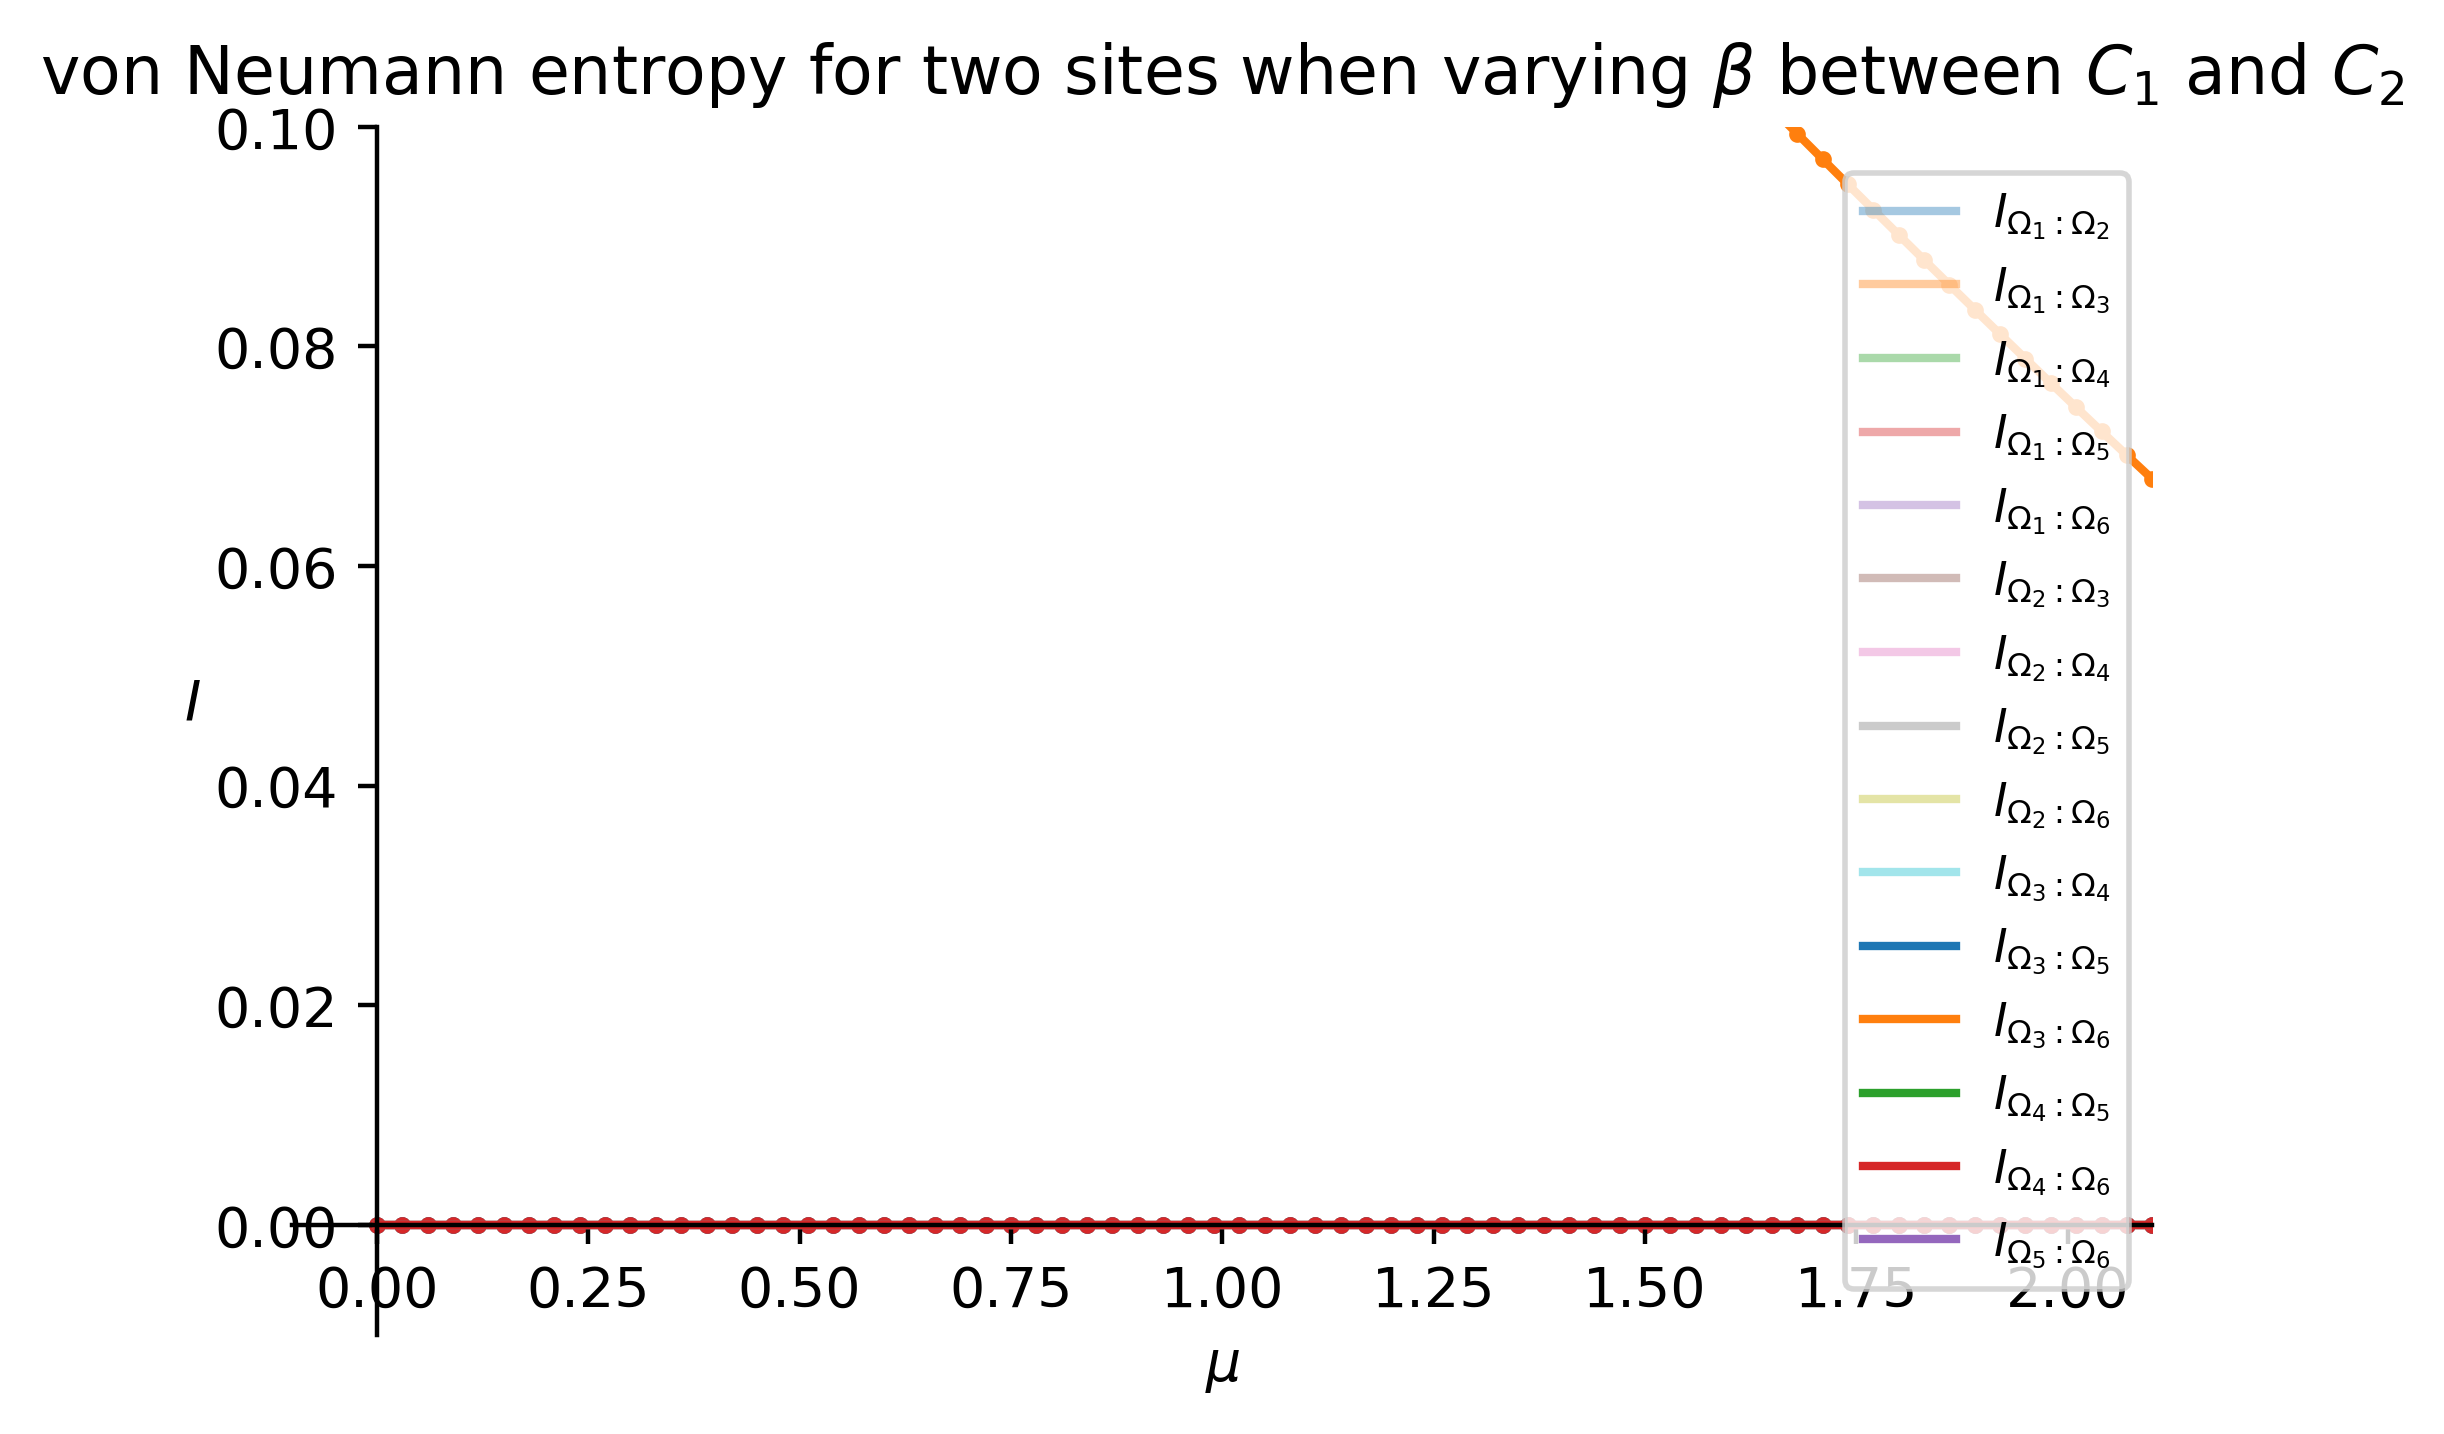

In [52]:
# Maak een nieuwe figuur en assen
fig, ax = plt.subplots(dpi= 400)

# Verplaats de spines (assenlijnen) naar de oorsprong
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Stel de x- en y-limieten in
ax.set_xlim(-0.1, 2.1)
ax.set_ylim(-0.01, 0.1)


# Plot de gegevens
index = 0
for i in range(6):
    for j in range(i+1, 6):
        if index >9:
            alpha = 1
        else:
            alpha = 0.4
        atoms = (str(i+1),str(j+1))
        plt.plot(potentials, [S_1_atom[k][i] + S_1_atom[k][j] - sublijst[index] for  k, sublijst in enumerate(S_2_atoms)], alpha = alpha, label=r'$I_{Ω_{%s}: Ω_{%s}}$' %atoms)
        plt.scatter(potentials, [S_1_atom[k][i] + S_1_atom[k][j] - sublijst[index] for  k, sublijst in enumerate(S_2_atoms)], s=4, alpha = alpha)
        index+=1
        
# Benoem de assen en titel 
plt.title('von Neumann entropy for two sites when varying $\\beta$ between $C_1$ and $C_2$')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$I$', rotation=0)

# Legenda
plt.legend(fontsize='small',loc = 'right')

# Toon de plot
plt.show()
